In [1]:
import numpy as np
import pandas as pd

In [2]:
import os

In [3]:
base_data_dir = './data/alzheimer'
train_base_dir = f'{base_data_dir}/train'
test_base_dir = f'{base_data_dir}/test'

In [4]:
class_distributions = {}
classes = os.listdir(train_base_dir)

In [5]:
for class_name in classes:
    class_distributions[class_name] = len(os.listdir(f'{train_base_dir}/{class_name}'))

In [6]:
class_distributions

{'MildDemented': 717,
 'ModerateDemented': 52,
 'NonDemented': 2560,
 'VeryMildDemented': 1792}

In [7]:
from matplotlib import pyplot as plt
import matplotlib.animation as animation

#### Distribution of classes in the train dataset

([0, 1, 2, 3],
 [Text(0, 0, 'MildDemented'),
  Text(1, 0, 'ModerateDemented'),
  Text(2, 0, 'NonDemented'),
  Text(3, 0, 'VeryMildDemented')])

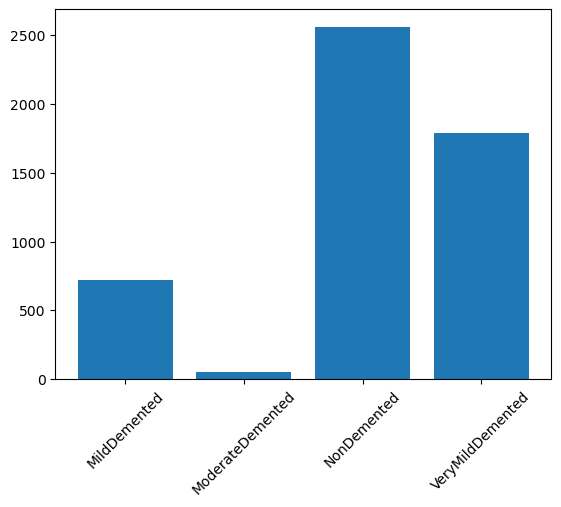

In [8]:
plt.bar(classes, class_distributions.values())
plt.xticks(rotation=45)

In [9]:
from PIL import Image

In [10]:
def get_image_dimensions(image_path):
    image = Image.open(image_path)
    return image.width, image.height

In [11]:
from tqdm import tqdm

In [12]:
class_dimensions_distributions = {
    'width': [],
    'height': [],
    'class': []
}

In [13]:
for class_name in classes:
    for image_name in tqdm(os.listdir(f'{train_base_dir}/{class_name}')):
        image_path = f'{train_base_dir}/{class_name}/{image_name}'
        image_width, image_height = get_image_dimensions(image_path)
        class_dimensions_distributions['width'].append(image_width)
        class_dimensions_distributions['height'].append(image_height)
        class_dimensions_distributions['class'].append(class_name)

100%|██████████| 1792/1792 [00:00<00:00, 7962.22it/s]


In [14]:
dimensions_df = pd.DataFrame(class_dimensions_distributions)
dim_df = pd.DataFrame(class_dimensions_distributions)

In [15]:
dimensions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5121 entries, 0 to 5120
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   width   5121 non-null   int64 
 1   height  5121 non-null   int64 
 2   class   5121 non-null   object
dtypes: int64(2), object(1)
memory usage: 120.2+ KB


In [16]:
dimensions_df.describe()

width  height
count  5121.0  5121.0
mean    176.0   208.0
std       0.0     0.0
min     176.0   208.0
25%     176.0   208.0
50%     176.0   208.0
75%     176.0   208.0
max     176.0   208.0

#### Distribution of photos' dimensions

In [17]:
dimensions_df['width'].value_counts(), dimensions_df['height'].value_counts()

(width
 176    5121
 Name: count, dtype: int64,
 height
 208    5121
 Name: count, dtype: int64)

In [18]:
dimensions_df.shape

(5121, 3)

In [19]:
def image_to_numpy(image_path):
    image = Image.open(image_path)
    return np.array(image)

In [20]:
# setting tensor to store all images' pixels
images = np.empty((5121, 208, 176))
class_to_idx = {}
for i in range(len(classes)):
    class_to_idx[classes[i]] = i
images_labels = np.empty(5121)

In [21]:
image_idx = 0
for class_name in classes:
    for image_name in tqdm(os.listdir(f'{train_base_dir}/{class_name}')):
        image_path = f'{train_base_dir}/{class_name}/{image_name}'
        images[image_idx] = image_to_numpy(image_path)
        images_labels[image_idx] = class_to_idx[class_name]
        image_idx += 1

100%|██████████| 1792/1792 [00:00<00:00, 3583.57it/s]


In [22]:
import seaborn as sns

#### Displaying heatmap for each class - whiter is weaker density

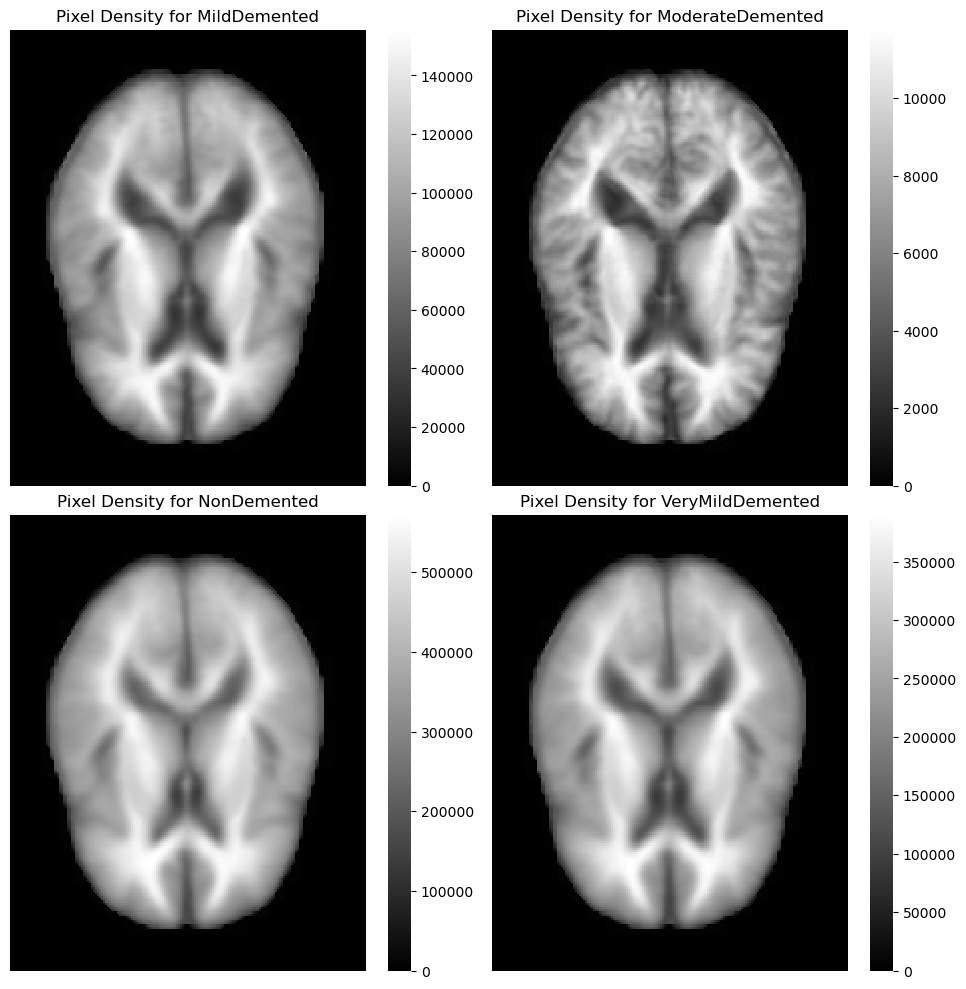

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True, sharex=True)
fig.tight_layout()

for i in range(len(classes)):
    ax = axes[i//2, i%2]
    class_images = images[np.where(images_labels == i)]
    heatmap = np.sum(class_images, axis=0)
    sns.heatmap(heatmap, ax=ax, cmap='gray')
    ax.set_title(f'Pixel Density for {classes[i]}')
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)

#### Drop all empty pixels to reduce dimensions

In [24]:
# get leftmost non empty pixel
non_empty_pixels = np.where(images > 0)[1:]

In [25]:
non_empty_pixels

(array([ 16,  16,  16, ..., 191, 191, 191], dtype=int64),
 array([ 56,  64,  65, ..., 112, 115, 116], dtype=int64))

In [26]:
uppermost_pixel = np.min(non_empty_pixels[0])
bottommost_pixel = np.max(non_empty_pixels[0])
leftmost_pixel = np.min(non_empty_pixels[1])
rightmost_pixel = np.max(non_empty_pixels[1])

In [27]:
# top left
leftmost_pixel, uppermost_pixel

(16, 16)

In [28]:
# bottom right
rightmost_pixel, bottommost_pixel

(159, 191)

In [29]:
# dropping
images = images[:, uppermost_pixel:bottommost_pixel+1, leftmost_pixel:rightmost_pixel+1]

In [30]:
images.shape

(5121, 176, 144)

In [31]:
df = pd.DataFrame(images.reshape(images.shape[0], -1))

In [32]:
df.shape

(5121, 25344)

In [33]:
# number of reduced dimensions
208 * 176 - 25344

11264

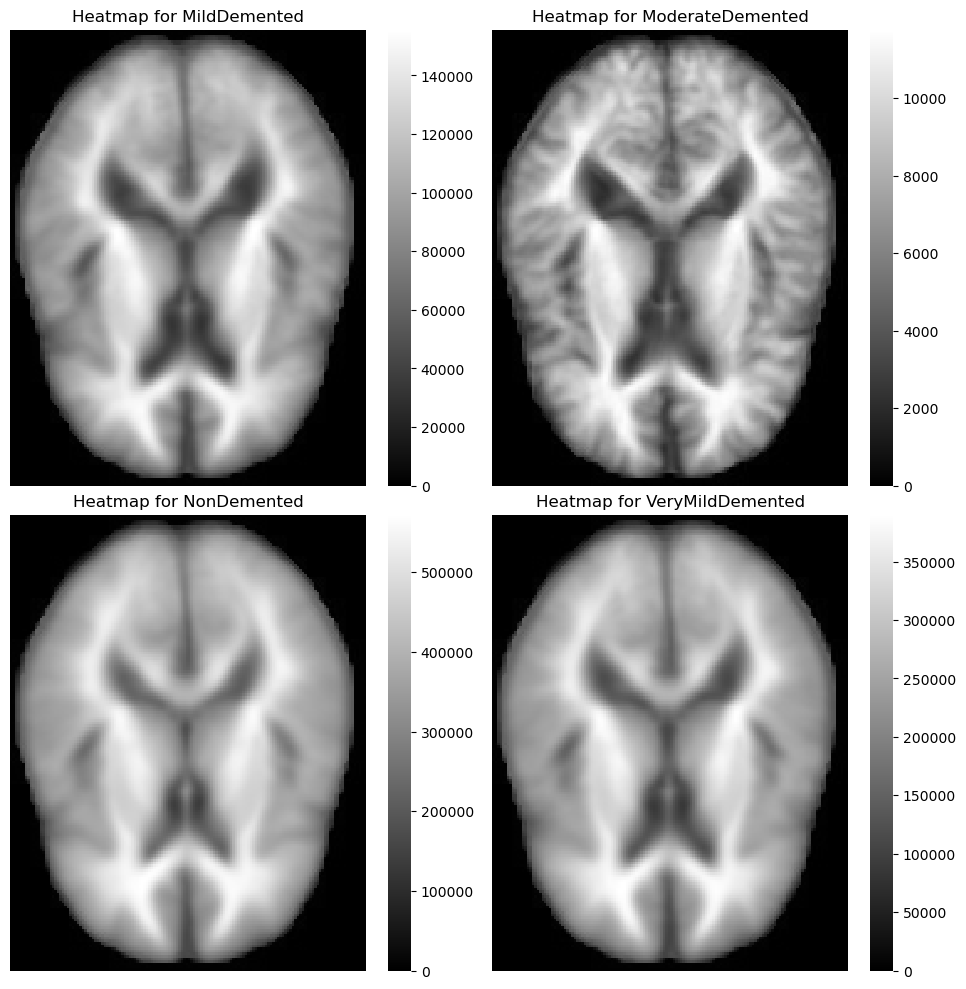

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True, sharex=True)
fig.tight_layout()

for i in range(len(classes)):
    ax = axes[i//2, i%2]
    class_images = images[np.where(images_labels == i)]
    heatmap = np.sum(class_images, axis=0)
    sns.heatmap(heatmap, ax=ax, cmap='gray')
    ax.set_title(f'Heatmap for {classes[i]}')
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)

#### NOT normalizing the images as the decoding process is less successful when dealing with a small range of numbers

In [35]:
# images = images / 255.0

#### Showing distribution of several pixels

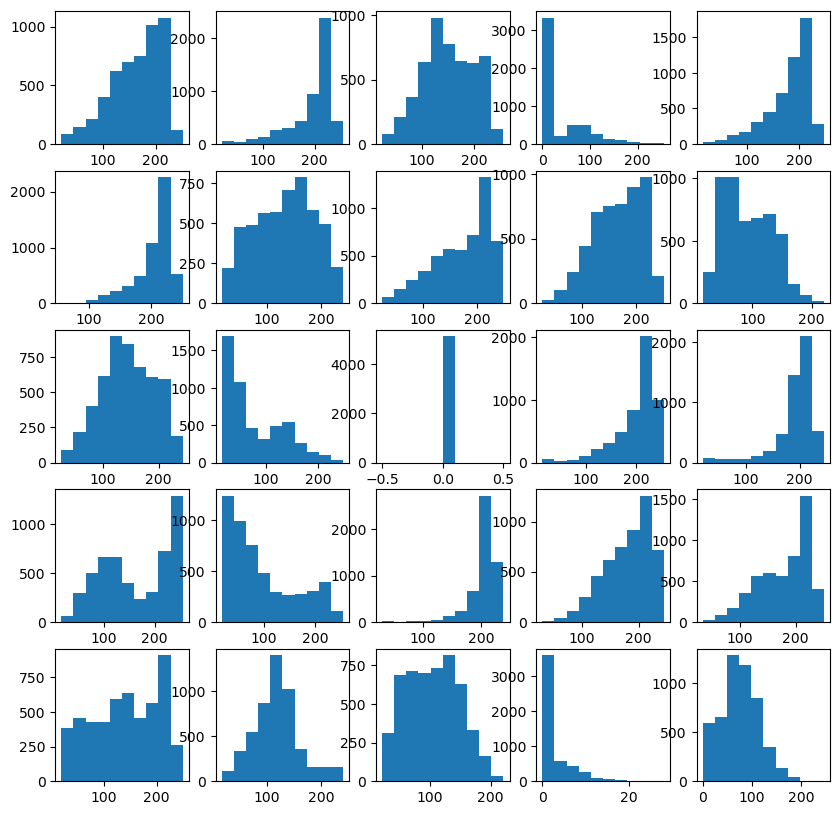

In [36]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

random_pixels = np.random.default_rng().choice(176 * 144, size=25, replace=False)

for i in range(25):
    ax = axes[i // 5, i % 5]
    ax.hist(images[:, random_pixels[i]//176, random_pixels[i]%144])

### Filters

In [37]:
import scipy as sp

In [38]:
def plot_side_by_side(first_images, second_images, first_title, second_title):
    # plot
    fig = plt.figure(constrained_layout=True, figsize=(18, 10))
    subfigs = fig.subfigures(2, 2)

    for class_idx, subfig in enumerate(subfigs.flat):
        subfig.suptitle(classes[class_idx])
        axes = subfig.subplots(1, 2)

        blurred_images = first_images[np.where(images_labels == class_idx)]
        blurred_heatmap = np.sum(blurred_images, axis=0)
        sns.heatmap(blurred_heatmap, ax=axes[0], cmap='gray')
        axes[0].set_title(first_title)
        axes[0].get_yaxis().set_visible(False)
        axes[0].get_xaxis().set_visible(False)

        original_images = second_images[np.where(images_labels == class_idx)]
        original_heatmap = np.sum(original_images, axis=0)
        sns.heatmap(original_heatmap, ax=axes[1], cmap='gray')
        axes[1].set_title(second_title)
        axes[1].get_yaxis().set_visible(False)
        axes[1].get_xaxis().set_visible(False)

#### Applying max filter with a 3x3 kernel

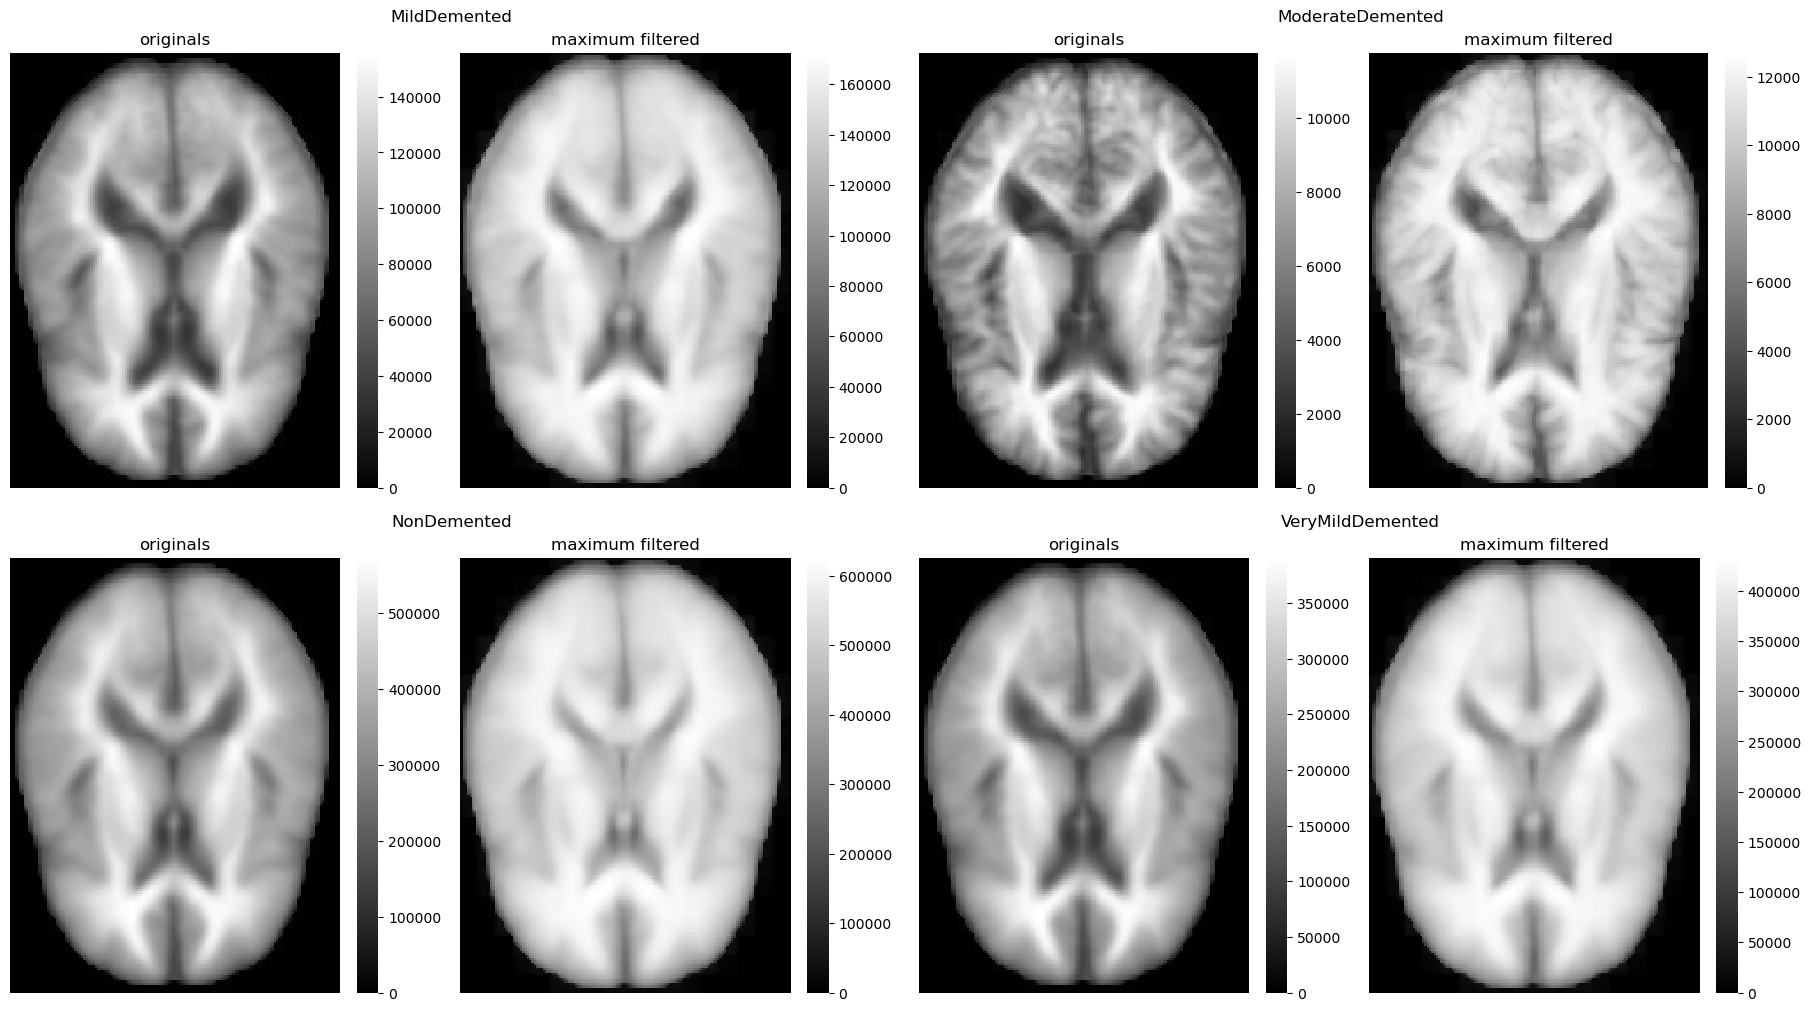

In [39]:
plot_side_by_side(images, sp.ndimage.maximum_filter(images, size=3), 'originals', 'maximum filtered')

#### Minimum filter

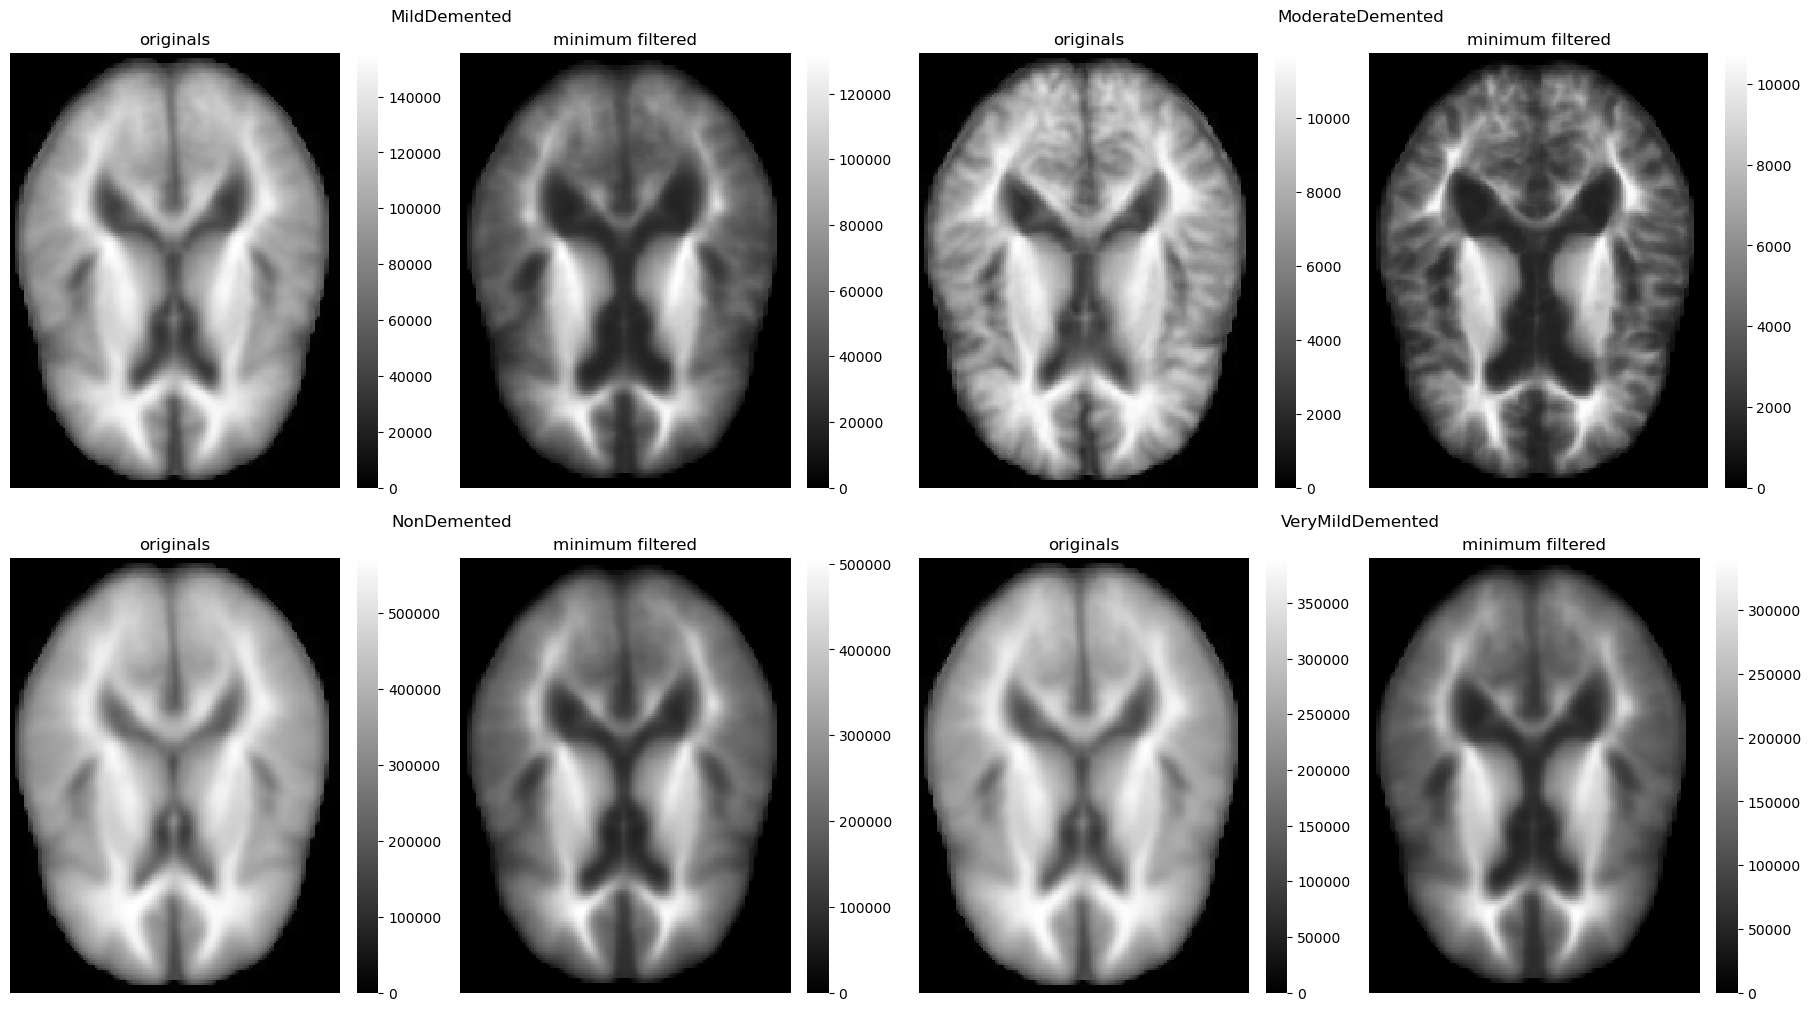

In [40]:
plot_side_by_side(images, sp.ndimage.minimum_filter(images, size=3), 'originals', 'minimum filtered')

#### Sobel filter

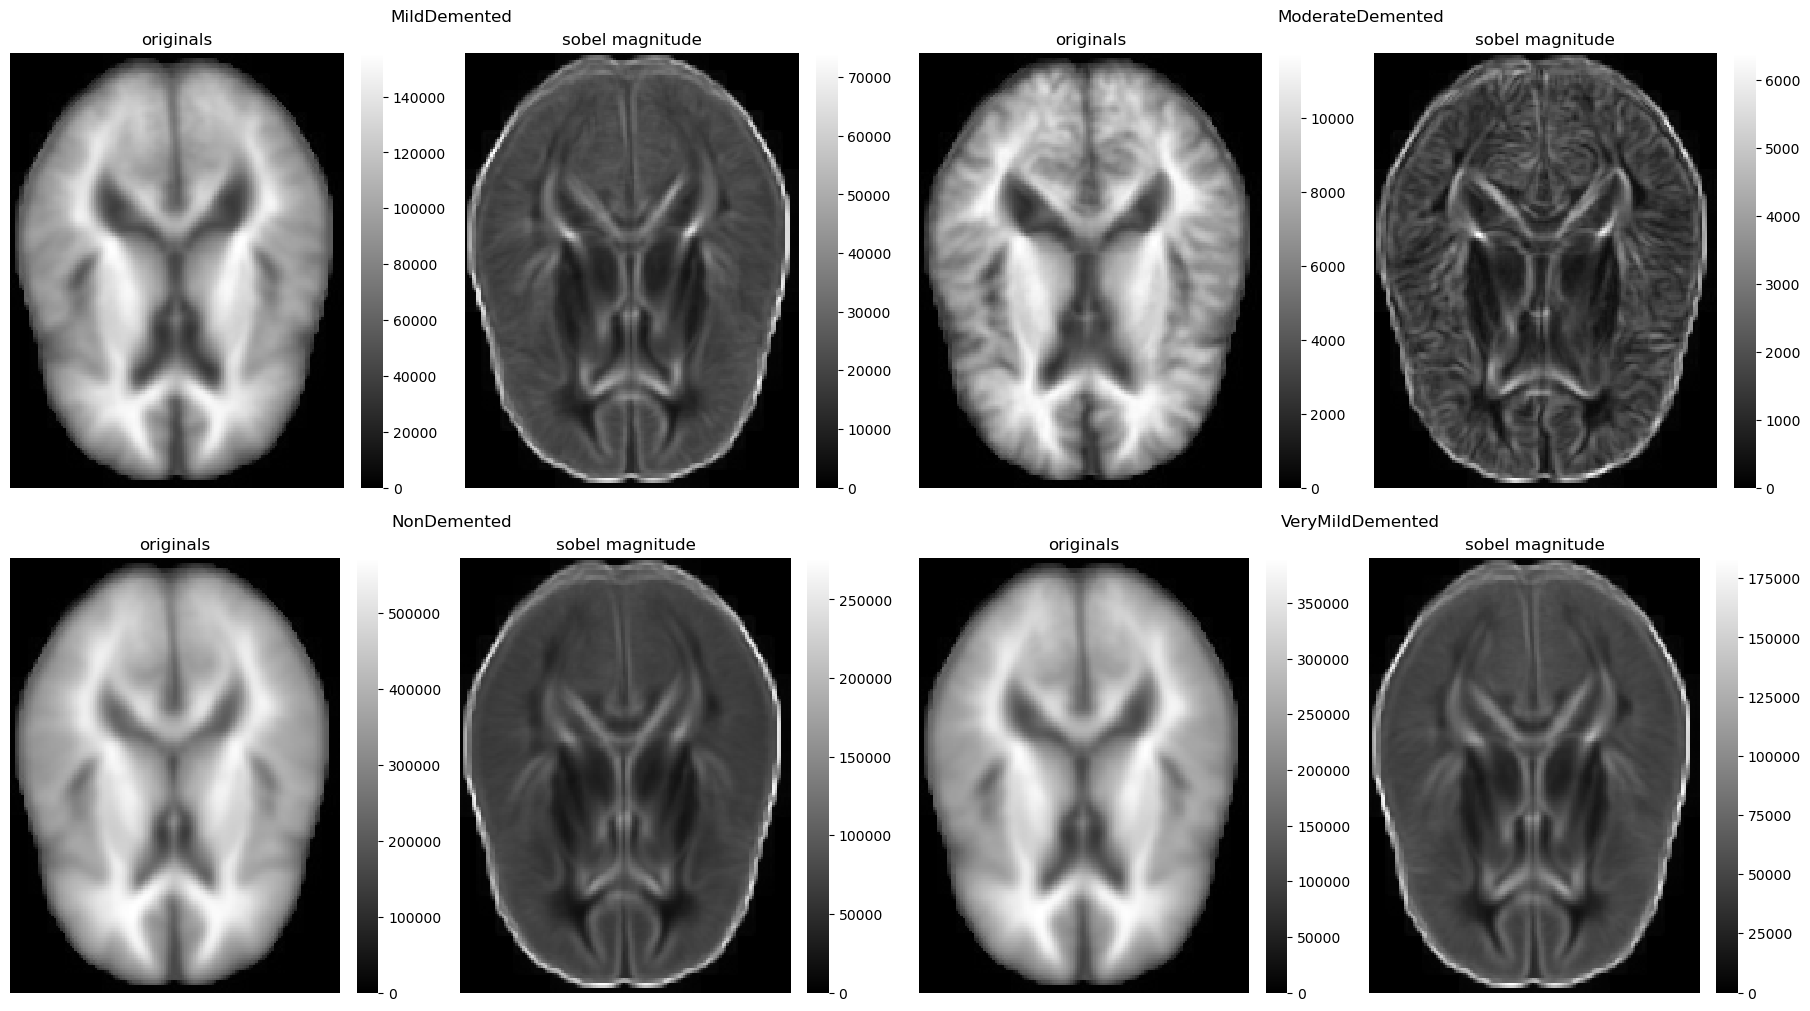

In [41]:
sobel_x_gradients = sp.ndimage.sobel(images, axis=1)
sobel_y_gradients = sp.ndimage.sobel(images, axis=2)
sobel_magnitude = np.sqrt(sobel_x_gradients ** 2 + sobel_y_gradients ** 2)
sobel_magnitude = 255 * sobel_magnitude / np.max(sobel_magnitude)
sobel_gradient_angle = np.arctan2(sobel_y_gradients, sobel_x_gradients)

plot_side_by_side(images, sobel_magnitude, 'originals', 'sobel magnitude')

#### Prewitt filter

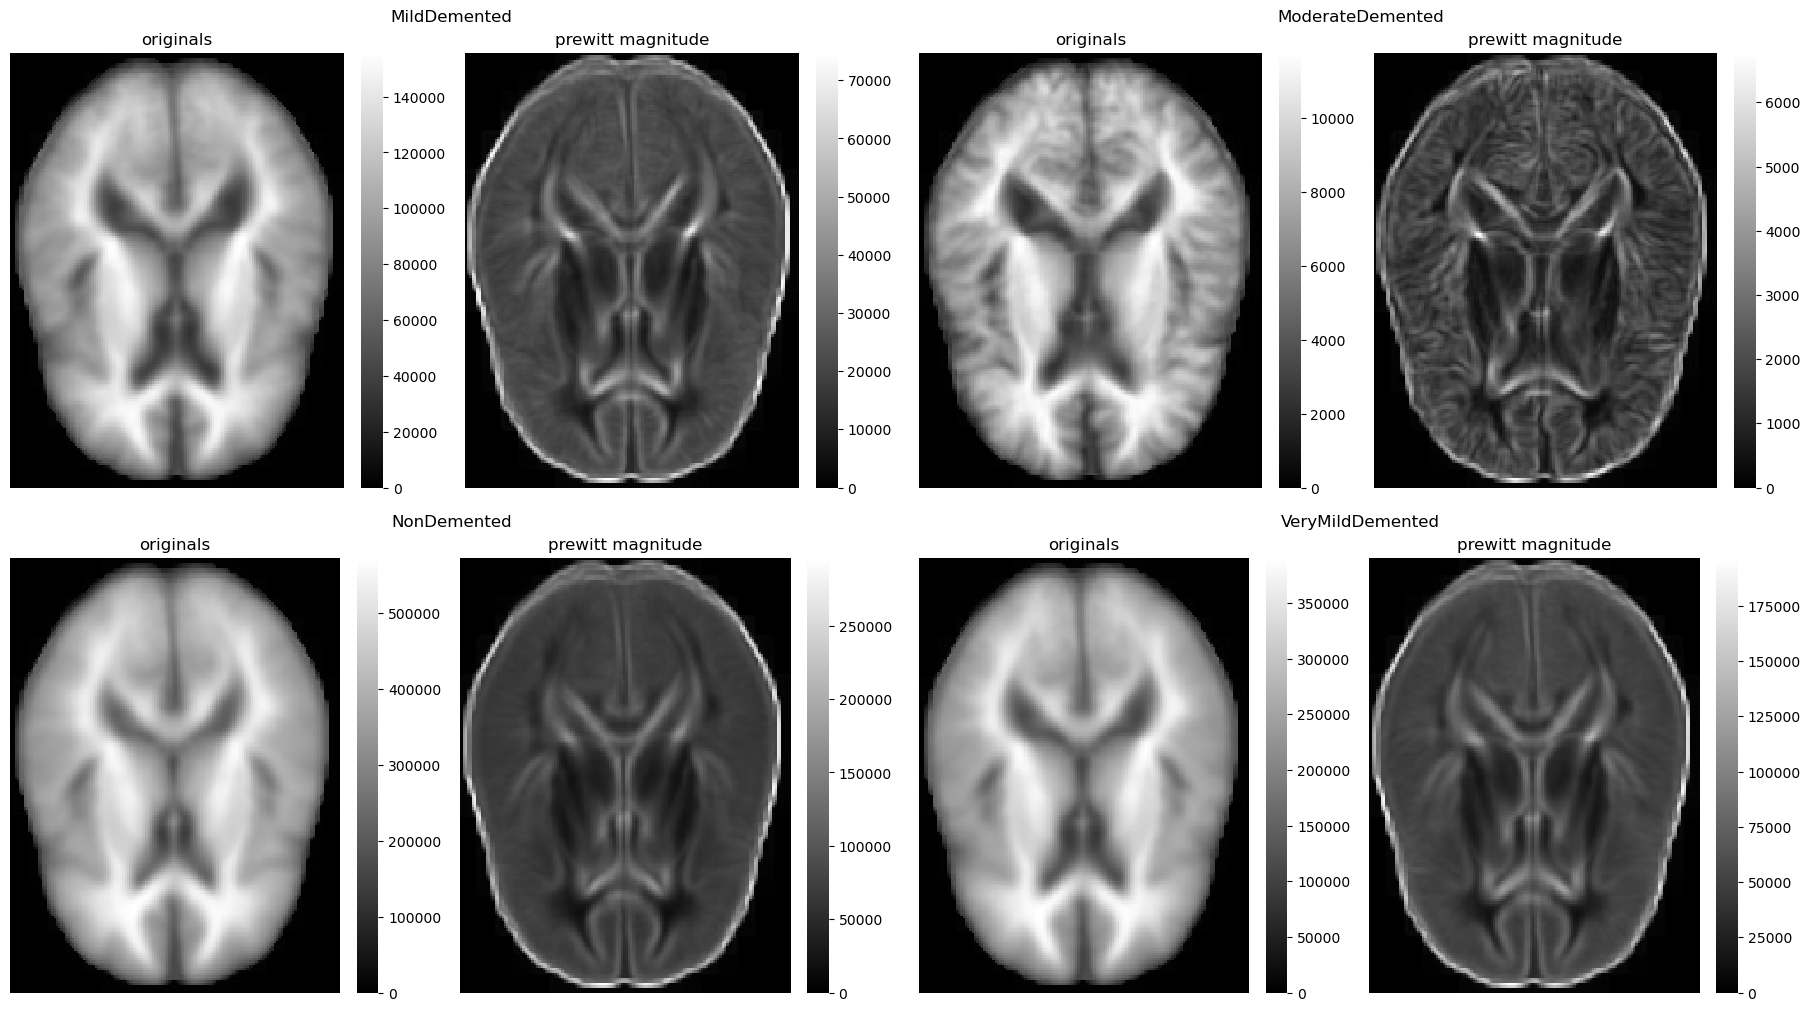

In [42]:
prewitt_x_gradients = sp.ndimage.prewitt(images, axis=1)
prewitt_y_gradients = sp.ndimage.prewitt(images, axis=2)
prewitt_magnitude = np.sqrt(prewitt_y_gradients ** 2 + prewitt_x_gradients ** 2)
prewitt_magnitude = 255 * prewitt_magnitude / prewitt_magnitude.max()
prewitt_gradient_angle = np.arctan2(prewitt_y_gradients, prewitt_x_gradients)

plot_side_by_side(images, prewitt_magnitude, 'originals', 'prewitt magnitude')

#### Compare prewitt with sobel

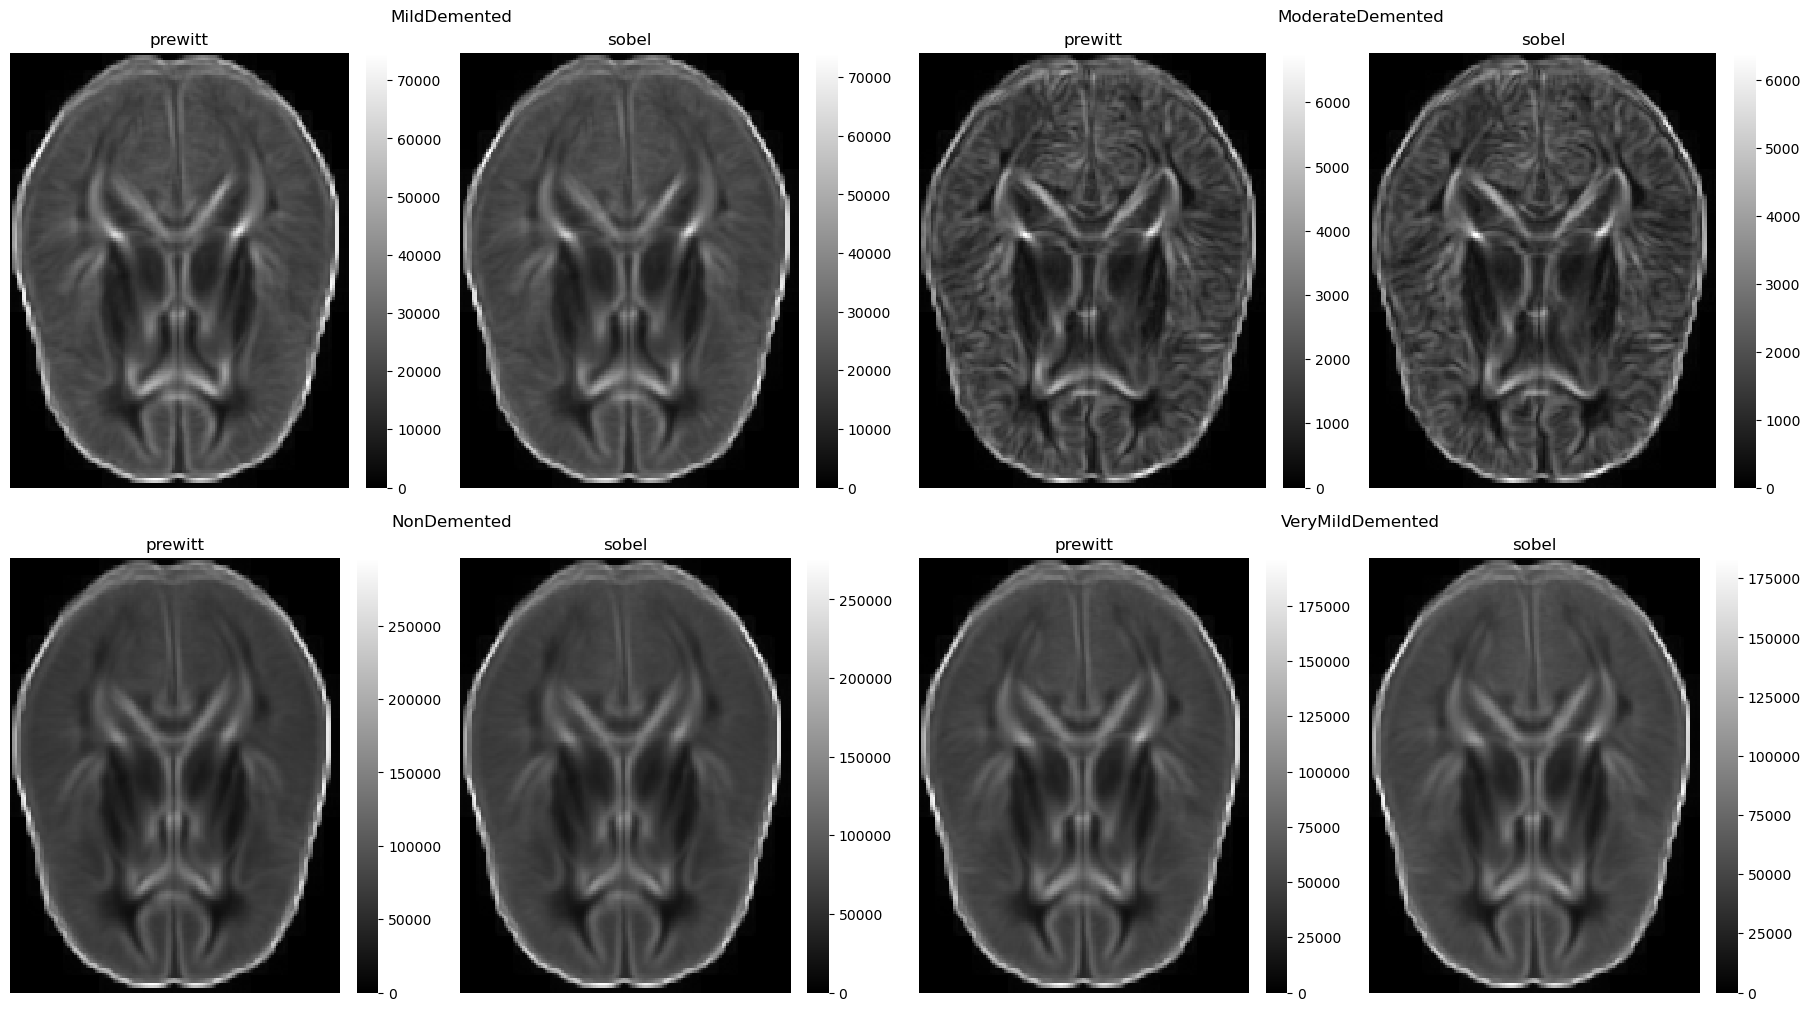

In [43]:
plot_side_by_side(prewitt_magnitude, sobel_magnitude, 'prewitt', 'sobel')

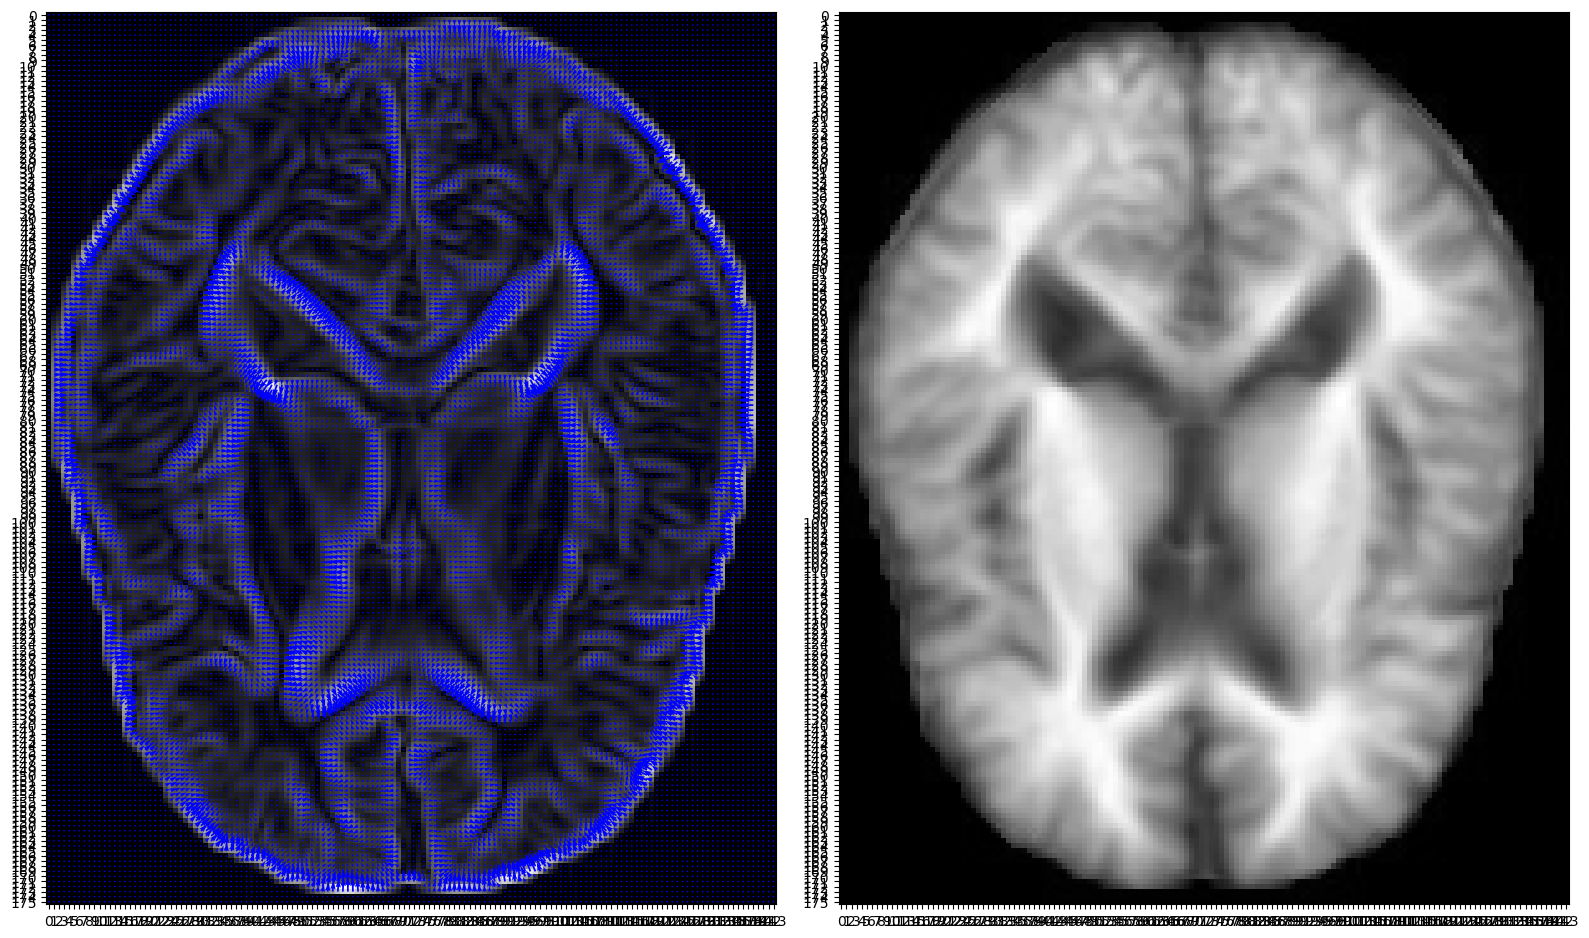

In [44]:
# x_start, x_end = 60, 80
# y_start, y_end = 70, 85
x_start, x_end = 0, images.shape[2]
y_start, y_end = 0, images.shape[1]

# test_image = images[0, y_start:y_end, x_start:x_end]
group_idx = 1
images_group = images[images_labels == group_idx]
test_image = np.sum(images_group, axis=0) / len(images_group)
# print(test_image, images[0, 84, 79])
prewitt_test_y_gradient = sp.ndimage.prewitt(test_image, axis=0)
prewitt_test_x_gradient = sp.ndimage.prewitt(test_image, axis=1)
prewitt_test_magnitude = np.sqrt(prewitt_test_x_gradient ** 2 + prewitt_test_y_gradient ** 2)
prewitt_test_magnitude = 255 * prewitt_test_magnitude / prewitt_test_magnitude.max()
prewitt_test_gradient_angle = np.arctan2(prewitt_test_y_gradient, prewitt_test_x_gradient)

y, x = np.mgrid[:y_end-y_start, :x_end-x_start]

fig, axes = plt.subplots(1, 2, figsize=(16, 10))

plt.setp(axes, xticks=np.arange(x_end - x_start), xticklabels=np.arange(x_start, x_end),
         yticks=np.arange(y_end - y_start), yticklabels=np.arange(y_start, y_end))
# plt.xticks(rotation=45)
# plt.yticks(rotation=45)

axes[0].imshow(prewitt_test_magnitude, cmap='gray', zorder=1)
# quiver plot is shown upside down so multiplying y coordinates and gradients by -1 for flipping the image and the arrows direction, respectively
axes[0].quiver(x, y, prewitt_test_x_gradient, prewitt_test_y_gradient,
            color='blue', angles='xy', scale_units='xy', units='width', scale=90, zorder=2)
# axes[0].streamplot(x, y, sobel_test_x_gradient, sobel_test_y_gradient,
#                    density=(test_image.shape[0]/30, test_image.shape[1]/30),
#                    arrowsize=1, integration_direction='forward', zorder=2)
axes[1].imshow(test_image, cmap='gray')
fig.tight_layout()

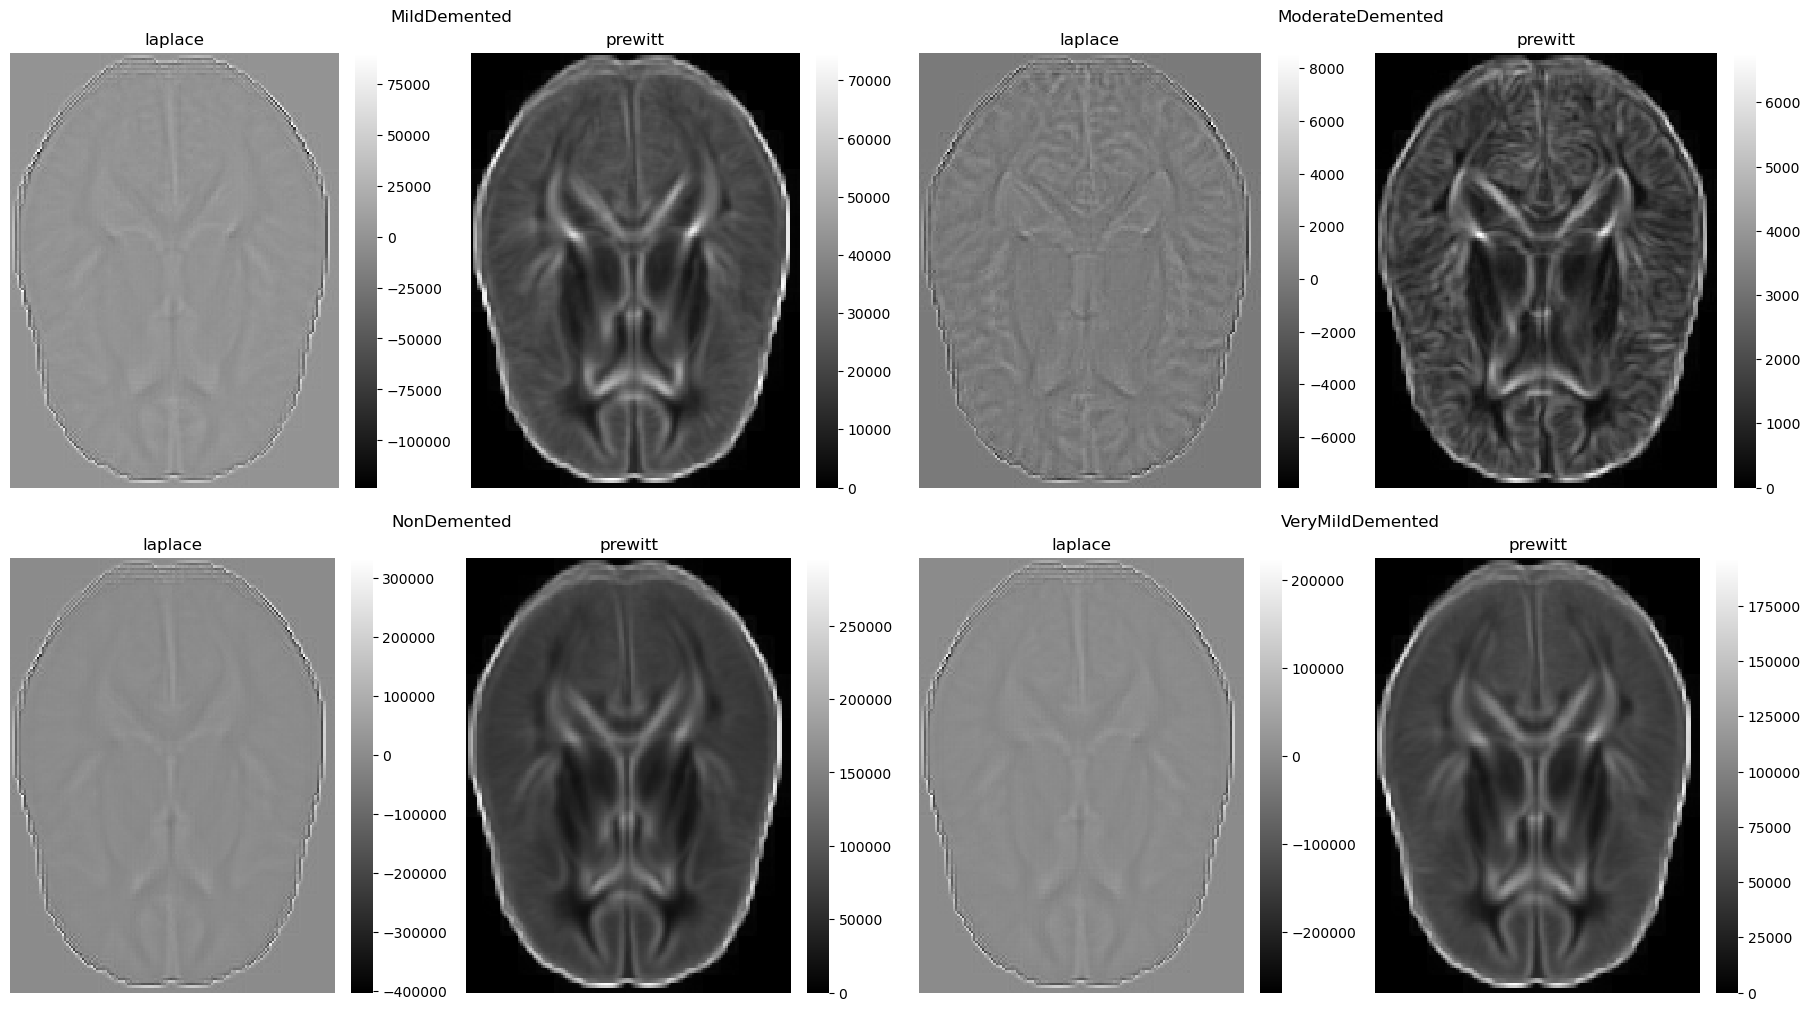

In [45]:
plot_side_by_side(sp.ndimage.laplace(images, cval=3), prewitt_magnitude, 'laplace', 'prewitt')

### Data Augmentation

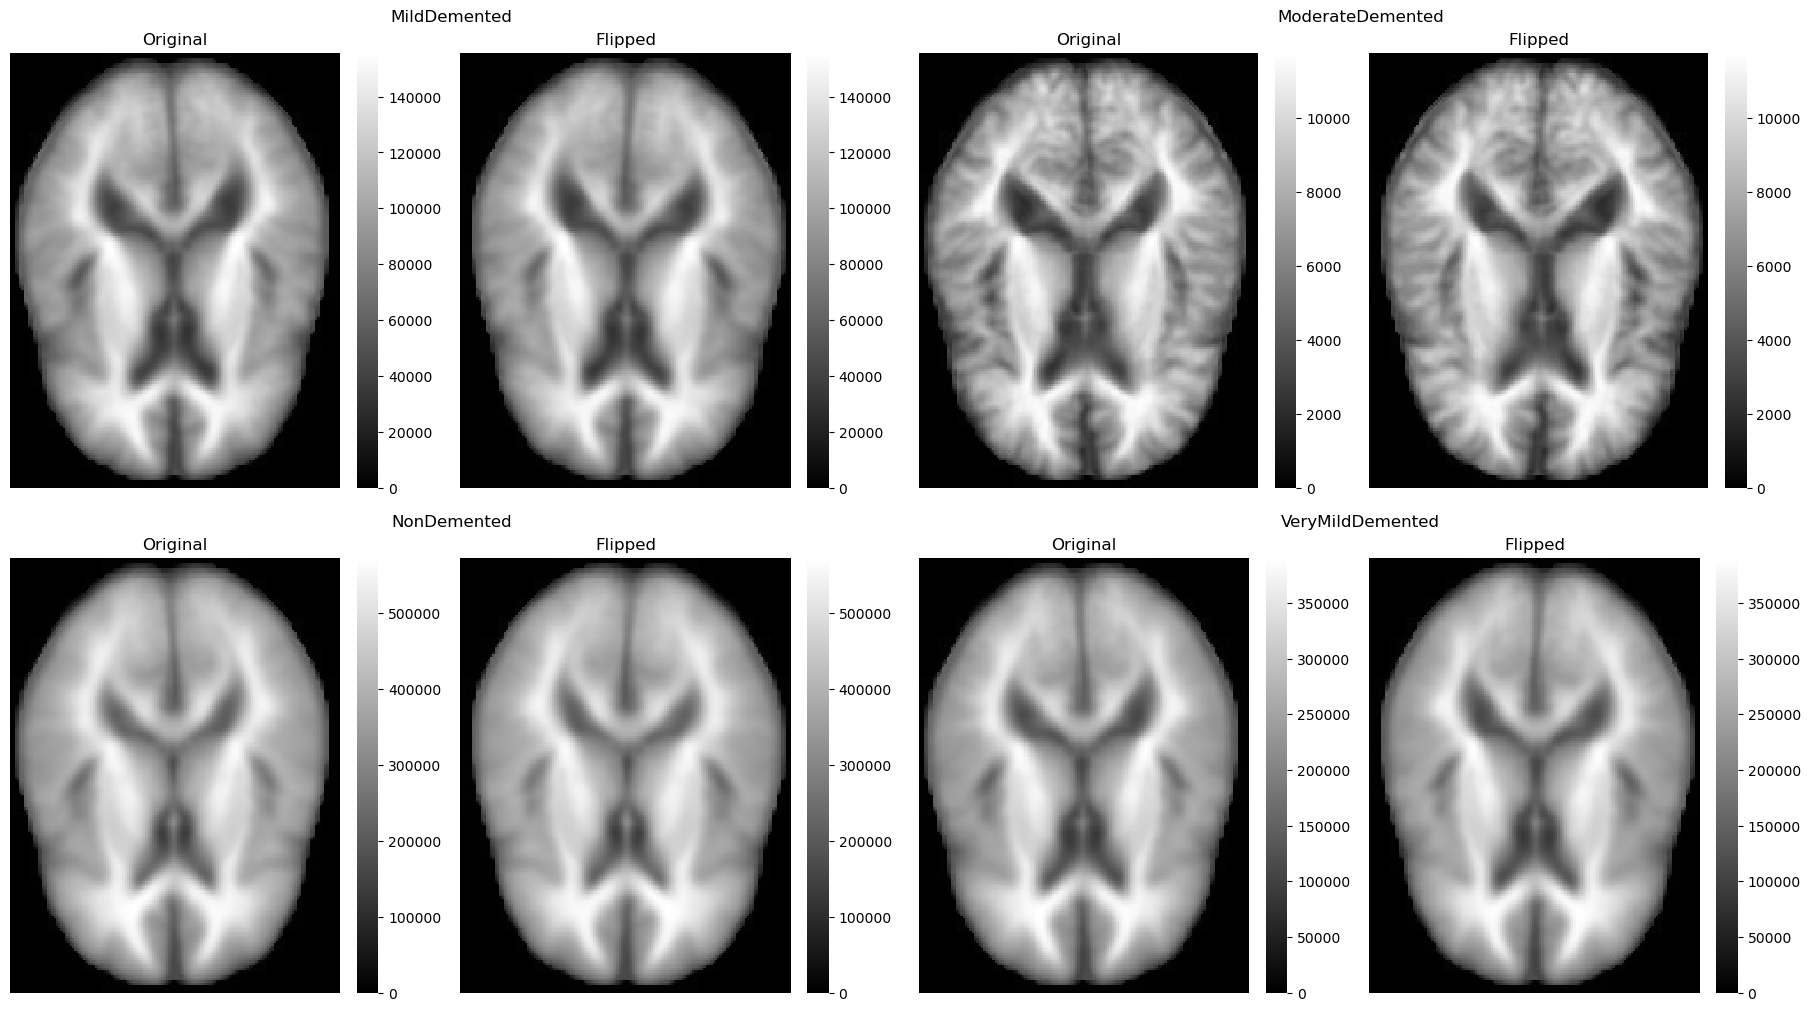

In [46]:
plot_side_by_side(images, images[..., :, ::-1], 'Original', 'Flipped')

In [47]:
# flipping the horizontal axis as we're assuming 
flipped_images = images[..., ::-1]

In [48]:
images = np.concatenate((images, flipped_images), axis=0)
images_labels = np.concatenate((images_labels, images_labels), axis=0)

In [49]:
images.shape, images_labels.shape

((10242, 176, 144), (10242,))

#### Training a variational autoencoder for augmenting randomized corrupted data to create new samples

In [50]:
import torch
from torch import nn

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#### Preparing data for PyTorch

In [52]:
class AlzheimerDataset(torch.utils.data.Dataset):
    def __init__(self, np_images, np_labels, transform=None, target_transform=None):
        self.X = torch.from_numpy(np_images).to(torch.float32).unsqueeze(dim=1) # adding the single channel
        self.y = torch.from_numpy(np_labels)
        
        self.transform = transform
        self.target_transform = target_transform
        
        self.len = len(self.X)
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        images = self.X[idx]
        labels = self.y[idx]
        if self.transform:
            images = self.transform(images)
        if self.target_transform:
            labels = self.target_transform(labels)
        
        return images, labels

#### Defining encoder and decoder

In [53]:
from torch.nn import functional as F

In [54]:
class MaxPoolBlock(nn.Module):
    def __init__(self, out_channels, kernel_size, padding, stride, ceil_mode):
        super().__init__()
        
        self.max_pool = nn.MaxPool2d(kernel_size=kernel_size, padding=padding, stride=stride, ceil_mode=ceil_mode, return_indices=True)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x, max_indices = self.max_pool(x)
        x = self.bn(x)
        x = self.relu(x)
        return x, max_indices

class MaxUnPoolBlock(nn.Module):
    def __init__(self, out_channels, kernel_size, padding, stride):
        super().__init__()

        self.max_unpool = nn.MaxUnpool2d(kernel_size=kernel_size, padding=padding, stride=stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x, max_indices, output_size):
        x = self.max_unpool(x, max_indices, output_size=output_size)
        x = self.bn(x)
        x = self.relu(x)
        return x

In [55]:
class ConvEncoder(nn.Module):
    def __init__(self, in_channels, encoded_dim, initial_out_channels=3, device='cpu'):
        super().__init__()
        
        self.device = device
        
        # non parameterized functionality
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        
        out_channels = initial_out_channels
        
        # input.shape = in_channels x 176 x 144
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(5, 5),
                               stride=(2, 2), padding=(3, 3), bias=False)
        # height = (176 + 2*3 - 1*(5-1) - 1)/2 + 1 = 89
        # width = (144 + 2*3 - 1*(5-1) - 1)/2 + 1 = 73
        # output shape = (batch x out_channels x 89 x 73)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.max_indices = None
        self.maxpool = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), 
                                    padding=(1, 1), ceil_mode=False, return_indices=True)
        # height = ((89 + 2*1 - 1*(3-1) - 1)/2 + 1 = 45
        # width = ((73 + 2*1 - 1*(3-1) - 1)/2 + 1 = 37
        
        # first residual block
        self.block0 = self.res_block(
            out_channels=out_channels,
            kernel_size=(3, 3),
            padding=1,
            stride=1
        )
        # using this "block" to be able to return max_indices from the max pool layer
        self.max_pool_block0 = MaxPoolBlock(
            out_channels=out_channels,
            kernel_size=(3, 3),
            padding=1,
            stride=1,
            ceil_mode=True
        )
        # down sampling
        self.down_sample0 = self.down_sample_block(
            in_channels=out_channels,
            out_channels=out_channels * 2,
            kernel_size=(3, 3),
            padding=1,
            stride=2
        )

        out_channels *= 2
        
        self.block1 = self.res_block(
            out_channels=out_channels,
            kernel_size=(3, 3),
            padding=1,
            stride=1
        )
        self.max_pool_block1 = MaxPoolBlock(
            out_channels=out_channels,
            kernel_size=(3, 3),
            padding=1,
            stride=1,
            ceil_mode=True
        )
        self.down_sample1 = self.down_sample_block(
            in_channels=out_channels,
            out_channels=out_channels * 2,
            kernel_size=(3, 3),
            padding=1,
            stride=2
        )

        out_channels *= 2
        
        self.block2 = self.res_block(
            out_channels=out_channels,
            kernel_size=(3, 3),
            padding=1,
            stride=1
        )
        self.max_pool_block2 = MaxPoolBlock(
            out_channels=out_channels,
            kernel_size=(3, 3),
            padding=1,
            stride=1,
            ceil_mode=True
        )
        self.down_sample2 = self.down_sample_block(
            in_channels=out_channels,
            out_channels=out_channels * 2,
            kernel_size=(3, 3),
            padding=1,
            stride=2
        )
        
        out_channels *= 2
        
        # 240 * initial_out_channels
        self.encoded_mean = nn.Linear(240 * initial_out_channels, out_features=encoded_dim, bias=True)
        self.encoded_log_variance = nn.Linear(240 * initial_out_channels, out_features=encoded_dim, bias=True)
        
        self.final_out_channels = out_channels
        
    def res_block(self, out_channels, kernel_size, padding, stride):
        return nn.Sequential(
            # bias is false as we have a bias in the BN layer
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels),
            self.relu,
            nn.MaxPool2d(kernel_size=kernel_size, padding=padding, stride=stride),
            nn.BatchNorm2d(out_channels),
        )
    
    def down_sample_block(self, in_channels, out_channels, kernel_size, padding, stride):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels),
            self.relu
        )
      
    def forward(self, X):
        X0 = self.conv1(X)
        X0 = self.bn1(X0)
        X0 = self.relu(X0)
        X0, initial_max_indices = self.maxpool(X0)
        
        # residual block
        Y0_ = X0 + self.block0(X0)
        # Y0_, max_indices0 = self.max_pool_block0(Y0_)
        # max_indices0 = max_indices0[..., :-1, :-1]
        Y0 = self.down_sample0(Y0_)
        Y0 = self.relu(Y0)
        
        Y1_ = Y0 + self.block1(Y0)
        # Y1_, max_indices1 = self.max_pool_block1(Y1_)
        # max_indices1 = max_indices1[..., :-1, :-1]
        Y1 = self.down_sample1(Y1_)
        Y1 = self.relu(Y1)
        
        Y2_ = Y1 + self.block2(Y1)
        # Y2_, max_indices2 = self.max_pool_block2(Y2_)
        # max_indices2 = max_indices2[..., :-1, :-1]
        Y2 = self.down_sample2(Y2_)
        Y2 = self.relu(Y2)
        
        Y = self.flatten(Y2)
        
        encoded_mean = self.encoded_mean(Y)
        encoded_log_var = self.encoded_log_variance(Y)
        epsilon = torch.randn_like(encoded_mean).to(dtype=torch.float32)
        encoded = encoded_mean + epsilon * torch.exp(encoded_log_var/2).to(dtype=torch.float32)
        
        return encoded, encoded_mean, encoded_log_var, initial_max_indices

In [56]:
class ConvDecoder(nn.Module):
    def __init__(self, encoded_dim, initial_out_channels, encoder_initial_out_channels):
        super().__init__()
        
        self.initial_out_channels = initial_out_channels
        out_channels = initial_out_channels
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.zero_padding = nn.ZeroPad2d(2)
        
        # 240 * encoder_initial_out_channels
        self.linear = nn.Linear(in_features=encoded_dim, out_features=240 * encoder_initial_out_channels, bias=True)
        
        out_channels = out_channels // 2

        # reshape to image shape before passing through this block
        self.up_sample0 = self.up_sample_block(
            in_channels=out_channels * 2,
            out_channels=out_channels,
            kernel_size=(3, 3),
            padding=1,
            stride=2
        )
        self.block0 = self.transpose_block(
            out_channels=out_channels,
            kernel_size=(3, 3),
            padding=1,
            stride=1
        )
        self.max_unpool_block0 = MaxUnPoolBlock(
            out_channels=out_channels,
            kernel_size=(3, 3),
            padding=1,
            stride=1
        )

        out_channels = out_channels // 2
        
        self.up_sample1 = self.up_sample_block(
            in_channels=out_channels * 2,
            out_channels=out_channels,
            kernel_size=(3, 3),
            padding=1,
            stride=2
        ) 
        self.block1 = self.transpose_block(
            out_channels=out_channels,
            kernel_size=(3, 3),
            padding=1,
            stride=1
        )
        self.max_unpool_block1 = MaxUnPoolBlock(
            out_channels=out_channels,
            kernel_size=(3, 3),
            padding=1,
            stride=1
        )
        
        out_channels = out_channels // 2
        
        self.up_sample2 = self.up_sample_block(
            in_channels=out_channels * 2,
            out_channels=out_channels,
            kernel_size=(3, 3),
            padding=1,
            stride=2
        )
        self.block2 = self.transpose_block(
            out_channels=out_channels,
            kernel_size=(3, 3),
            padding=1,
            stride=1
        )
        self.max_unpool_block2 = MaxUnPoolBlock(
            out_channels=out_channels,
            kernel_size=(2, 2),
            padding=1,
            stride=1
        )
        
        self.max_indices = None
        self.max_unpool = nn.MaxUnpool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.conv_transpose1 = nn.ConvTranspose2d(out_channels, 1, kernel_size=(5, 5),
                                                  stride=(2, 2), padding=(2, 2), bias=False)
        self.bn1 = nn.BatchNorm2d(1)
        
    def transpose_block(self, out_channels, kernel_size, padding, stride):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels=out_channels, out_channels=out_channels,
                               kernel_size=kernel_size, padding=padding, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels),
            self.relu,
            nn.ConvTranspose2d(in_channels=out_channels, out_channels=out_channels,
                               kernel_size=kernel_size, padding=padding, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels),
        )
    
    def up_sample_block(self, in_channels, out_channels, kernel_size, padding, stride):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels,
                               kernel_size=kernel_size, padding=padding, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels),
            self.relu
        )
    
    def set_max_indices(self, max_indices):
        self.max_indices = max_indices

    def forward(self, X):
        X0 = self.linear(X)
        # reshaping to (batch, channels, pixels) shape
        X0 = X0.reshape(-1, self.initial_out_channels, 6, 5)
        # X0 = X0.reshape(-1, self.initial_out_channels, 12, 10)
        X0 = self.relu(X0)
        
        Y0_ = self.up_sample0(X0)
        # Y0_ = self.max_unpool_block0(Y0_, max_indices[-1], output_size=max_shapes[-1])
        Y0 = Y0_ + self.block0(Y0_)
        Y0 = self.relu(Y0)
        
        Y1_ = self.up_sample1(Y0)
        # Y1_ = self.max_unpool_block1(Y1_, max_indices[-2], output_size=max_shapes[-2])
        Y1 = Y1_ + self.block1(Y1_)
        Y1 = self.relu(Y1)
        
        Y2_ = self.up_sample2(Y1)
        # Y2_ = self.max_unpool_block2(Y2_, max_indices[-3], output_size=max_shapes[-3])
        Y2 = Y2_ + self.block2(Y2_)
        Y2 = self.relu(Y2)
        Y2 = self.zero_padding(Y2)
        
        Y = self.max_unpool(Y2, self.max_indices)
        num_pixels_to_cut = 1
        Y = self.conv_transpose1(Y)
        Y = self.bn1(Y)
        Y = self.relu(Y)
        # remove last row and column in the image
        Y = Y[..., :-num_pixels_to_cut, :-num_pixels_to_cut]

        # use sigmoid only if pixel values are in [0, 1] range
        # Y = self.sigmoid(Y)
        
        return Y

#### KL Divergence loss function to learn the mean and standard deviation of the latent space's distribution

In [57]:
def kl_divergence_loss(mean, log_var):
    kl_sum = torch.sum(1 + log_var - mean**2 - torch.exp(log_var), dim=1)
    return -0.5 * kl_sum.mean(dim=0)

In [58]:
class AutoEncoder(nn.Module):
    def __init__(self, in_channels, encoded_dim, initial_out_channels):
        super().__init__()
        # latent space is encoded_dim dimensions
        self.encoder = ConvEncoder(in_channels=in_channels, encoded_dim=encoded_dim,
                                   initial_out_channels=initial_out_channels, device=device)
        self.decoder = ConvDecoder(encoded_dim=encoded_dim,
                                   initial_out_channels=self.encoder.final_out_channels,
                                   encoder_initial_out_channels=initial_out_channels)

    def forward(self, X):
        encoded, encoded_mean, encoded_log_var, max_indices = self.encoder(X)
        # when using only the decoder the last call of this line will be applied for every forward call in the decoder
        # limits usage in batches with the last batch size that was used in training
        self.decoder.set_max_indices(max_indices)
        decoded = self.decoder(encoded)
        
        return encoded, encoded_mean, encoded_log_var, decoded

In [59]:
alzheimer_dataset = AlzheimerDataset(images, images_labels)

#### Using Optuna for hyperparameters optimization
##### Initially, the tuning was manual, and I was getting ~8000 Overall loss values (MSE + lambda * KLE Div), and after changing the optimizer from Adam to SGD and tweaking the learning rate and adding dampening, it went down to ~2000. With Optuna it found a set of hyperparameters with a loss value of 600!

In [60]:
# using tensorboard for displaying training progress and metrices in real time
from torch.utils.tensorboard import SummaryWriter
import optuna

In [61]:
def train_epoch(model, optimizer, loss, regularization_lambda, dataloader, val_dataset, overall_losses, kl_divergence_losses, main_losses,val_overall_losses, val_kl_divergence_losses, val_main_losses, epoch, scheduler=None):
    for batch_idx, (batch_X, _) in enumerate(dataloader):
        batch_X = batch_X.to(device)
        
        optimizer.zero_grad()
        
        batch_encoded_output, batch_encoded_mean, batch_encoded_log_var, batch_decoded_output = model(batch_X)
        # batch_decoded_output = autoencoder(batch_X)
    
        batch_main_loss = loss(batch_decoded_output, batch_X)
        # batch_loss = batch_mse_loss
        batch_kl_divergence_loss = kl_divergence_loss(batch_encoded_mean, batch_encoded_log_var)
        batch_loss = batch_main_loss + regularization_lambda * batch_kl_divergence_loss
    
        batch_loss.backward()
        optimizer.step()
    
    # updating train metrics
    overall_losses[epoch] = batch_loss.item()
    kl_divergence_losses[epoch] = batch_kl_divergence_loss.item()
    main_losses[epoch] = batch_main_loss.item()
        
    # validation
    with torch.no_grad():
        model.eval()
        encoded_output, encoded_mean, encoded_log_var, decoded_output = model(val_dataset.X.to(device))
        # decoded_output = model(dataset.X.to(device))
        loss_value = loss(decoded_output, val_dataset.X.to(device))
        # output_loss = loss_value
        kl_divergence_loss_value = kl_divergence_loss(encoded_mean, encoded_log_var)
        output_loss = loss_value + regularization_lambda * kl_divergence_loss_value

        val_overall_losses[epoch] = output_loss.item()
        val_kl_divergence_losses[epoch] = kl_divergence_loss_value.item()
        val_main_losses[epoch] = loss_value.item()

    # update learning rate after each epoch to have equal effect for every batch
    if scheduler is not None and epoch < 75:
        scheduler.step()
        
    

In [62]:
# if trial is None we're going for multi-objective optimization or we're normally training
def train(trial, model, optimizer, loss, epochs, regularization_lambda, dataloader, val_dataset, scheduler=None, plot=True, show_progress=True):
    # writer = SummaryWriter(log_dir='./logs')
    
    overall_losses, val_overall_losses = torch.zeros(epochs), torch.zeros(epochs)
    kl_divergence_losses, val_kl_divergence_losses = torch.zeros(epochs), torch.zeros(epochs)
    main_losses, val_main_losses = torch.zeros(epochs), torch.zeros(epochs)
    
    # using tqdm has conflicts with optuna's study progress bar
    epochs_range = tqdm(range(epochs)) if show_progress else range(epochs)
    for epoch in epochs_range:
        model.train()
        
        train_epoch(
            model=model,
            optimizer=optimizer, 
            loss=loss,
            epoch=epoch,
            regularization_lambda=regularization_lambda,
            dataloader=dataloader,
            val_dataset=val_dataset,
            val_overall_losses=val_overall_losses,
            val_kl_divergence_losses=val_kl_divergence_losses,
            val_main_losses=val_main_losses,
            overall_losses=overall_losses,
            kl_divergence_losses=kl_divergence_losses,
            main_losses=main_losses,
            scheduler=scheduler
        )
        
        if trial is not None:
            trial.report(overall_losses[epoch].item(), epoch)

            if trial.should_prune():
                raise optuna.TrialPruned()

    if plot:
        fig, axes = plt.subplots(1, 3, figsize=(16, 6))

        axes[0].plot(overall_losses.cpu(), color='blue', label='Train')
        axes[0].plot(val_overall_losses.cpu(), color='orange', label='Validation')
        axes[0].set_title('Overall Loss')
        
        axes[1].plot(kl_divergence_losses.cpu(), color='blue', label='Train')
        axes[1].plot(val_kl_divergence_losses.cpu(), color='orange', label='Validation')
        axes[1].set_title('KL Divergence Loss')
        
        axes[2].plot(main_losses.cpu(), color='blue', label='Train')
        axes[2].plot(val_main_losses.cpu(), color='orange', label='Validation')
        axes[2].set_title('Main Loss')
        
        fig.legend()
    # writer.flush()
    
    return (overall_losses, val_overall_losses), (kl_divergence_losses, val_kl_divergence_losses), (main_losses, val_main_losses)

In [63]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true))

In [64]:
def get_loss_function(loss_idx):
    return nn.MSELoss() if loss_idx == 0 else RMSELoss()

In [65]:
def initialize_hyperparameters(trial):
    encoded_dim = trial.suggest_int('encoded_dim', 2, 64*64)
    initial_out_channels = trial.suggest_int('initial_out_channels', 2, 8)
    # autoencoder = AutoEncoder(in_channels=1, encoded_dim=encoded_dim, initial_out_channels=initial_out_channels).to(device)

    lr = trial.suggest_float('lr', 1e-3, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 0.1, 0.4, log=True)
    momentum = trial.suggest_float('momentum', 0, 0.5)
    dampening = trial.suggest_float('dampening', 0, 0.5)
    # optimizer = torch.optim.SGD(autoencoder.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, dampening=dampening)

    scheduler_gamma = trial.suggest_float('scheduler_gamma', 0.8, 0.999)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_gamma)

    kl_divergence_lambda = trial.suggest_float('kl_divergence_lambda', 0.5, 5)

    epochs = trial.suggest_int('epochs', 50, 100)
    batch_size = trial.suggest_int('batch_size', 32, 256)

    loss_idx = trial.suggest_int('loss_idx', 0, 0)
    # loss = get_loss_function(loss_idx)

    # dataset_idx = trial.suggest_int('dataset_idx', 0, 2)
    # dataset = datasets[dataset_idx]

    # dataloader = torch.utils.data.DataLoader(alzheimer_dataset, batch_size=batch_size, shuffle=True)

    return encoded_dim, initial_out_channels, lr, weight_decay, momentum, dampening, scheduler_gamma, kl_divergence_lambda, epochs, batch_size, loss_idx

In [66]:
def multi_objective(trial):
    (encoded_dim,
     initial_out_channels,
     lr,
     weight_decay,
     momentum,
     dampening,
     scheduler_gamma,
     kl_divergence_lambda,
     epochs,
     batch_size,
     loss_idx) = initialize_hyperparameters(trial)
    
    autoencoder = AutoEncoder(in_channels=1, encoded_dim=encoded_dim, initial_out_channels=initial_out_channels).to(device)
    optimizer = torch.optim.SGD(autoencoder.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, dampening=dampening)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_gamma)
    loss = get_loss_function(loss_idx)

    # dataset_idx = trial.suggest_int('dataset_idx', 0, 2)
    # dataset = datasets[dataset_idx]

    dataloader = torch.utils.data.DataLoader(alzheimer_dataset, batch_size=batch_size, shuffle=True)

    overall, kl_divergence, main_loss = train(
        model=autoencoder,
        optimizer=optimizer,
        loss=loss,
        epochs=epochs,
        regularization_lambda=kl_divergence_lambda,
        dataloader=dataloader,
        val_dataset=alzheimer_dataset,
        scheduler=scheduler,
        plot=False,
        show_progress=False,
        trial=None
    )

    overall_train_losses, val_overall_losses = overall
    kl_divergence_train_losses, val_kl_divergence_train_losses = kl_divergence
    main_train_losses, val_main_losses = main_loss

    # saving the best trained model exploded the VRAM so we'll have to do with the best parameters and then retrain 
    # trial.set_user_attr(key='best_booster', value=autoencoder)

    return kl_divergence_train_losses[-1].item(), main_train_losses[-1].item()  
    

In [67]:
def objective(trial):
    (encoded_dim,
     initial_out_channels,
     lr,
     weight_decay,
     momentum,
     dampening,
     scheduler_gamma,
     kl_divergence_lambda,
     epochs,
     batch_size,
     loss_idx) = initialize_hyperparameters(trial)

    autoencoder = AutoEncoder(in_channels=1, encoded_dim=encoded_dim, initial_out_channels=initial_out_channels).to(device)
    optimizer = torch.optim.SGD(autoencoder.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, dampening=dampening)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_gamma)
    loss = get_loss_function(loss_idx)
    
    dataloader = torch.utils.data.DataLoader(alzheimer_dataset, batch_size=batch_size, shuffle=True)
    
    overall, _, _ = train(
        model=autoencoder,
        optimizer=optimizer,
        loss=loss,
        epochs=epochs,
        regularization_lambda=kl_divergence_lambda,
        dataloader=dataloader,
        val_dataset=alzheimer_dataset,
        scheduler=scheduler,
        plot=False,
        show_progress=True,
        trial=trial
    )
    
    overall_train_losses, val_overall_losses = overall
    
    # saving the best trained model exploded the VRAM so we'll have to do with the best parameters and then retrain 
    # trial.set_user_attr(key='best_booster', value=autoencoder)
    
    return_value = overall_train_losses[-1].item()
    # # if loss is RMSE, return squared value to compare same range of values with MSE
    return np.power(return_value, 2) if loss_idx == 1 else return_value

In [68]:
# from importlib import reload

In [69]:
import db
from db.optuna_report import report_optuna_trial, report_study_best_loss_value, get_best_hyperparameters

In [70]:
def callback(study, trial):
    report_optuna_trial(study, trial)

In [71]:
def optimize(is_multi_objective):
    directions = ['minimize', 'minimize'] if is_multi_objective else ['minimize']
    objective_func = multi_objective if is_multi_objective else objective
    show_progress_bar = True if is_multi_objective else False
    
    study = optuna.create_study(directions=directions)
    study.optimize(objective_func, n_trials=100, timeout=12000, show_progress_bar=show_progress_bar, gc_after_trial=True, callbacks=[callback])
    return study

In [72]:
is_multi_objective = False
study = optimize(is_multi_objective=is_multi_objective)

[I 2024-10-24 21:00:17,802] A new study created in memory with name: no-name-ea9fc6eb-d678-46e6-8e94-adab3e2f4730
100%|██████████| 66/66 [01:08<00:00,  1.04s/it]
[I 2024-10-24 21:01:27,045] Trial 0 finished with value: 3608.749267578125 and parameters: {'encoded_dim': 2556, 'initial_out_channels': 2, 'lr': 0.0015016760144381425, 'weight_decay': 0.15327396793475337, 'momentum': 0.21105335709088635, 'dampening': 0.3309388611465535, 'scheduler_gamma': 0.9236491417641808, 'kl_divergence_lambda': 1.9270226900341436, 'epochs': 66, 'batch_size': 183, 'loss_idx': 0}. Best is trial 0 with value: 3608.749267578125.
100%|██████████| 57/57 [01:16<00:00,  1.34s/it]
[I 2024-10-24 21:02:48,896] Trial 1 finished with value: 5965.86376953125 and parameters: {'encoded_dim': 4084, 'initial_out_channels': 4, 'lr': 0.0014791779522746716, 'weight_decay': 0.10725844973254486, 'momentum': 0.039115418055249374, 'dampening': 0.49754004044454264, 'scheduler_gamma': 0.8517130162460477, 'kl_divergence_lambda': 2.5

In [73]:
# pruned_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.PRUNED])
# completed_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])

In [74]:
# update the best loss value on study table with the correct dataset size to get best normalized loss value overall
report_study_best_loss_value(dataset_size=alzheimer_dataset.X.shape[0])

IndexError: list index out of range

In [77]:
import optuna.visualization as vis

In [115]:
if is_multi_objective:
    vis.plot_optimization_history(study, target=lambda t: t.values[0], target_name='KL Divergence')
else:
    vis.plot_optimization_history(study)

In [114]:
if is_multi_objective:
    vis.plot_optimization_history(study, target=lambda t: t.values[1], target_name='MSE')

In [117]:
vis.plot_optimization_history(study)

In [116]:
vis.plot_param_importances(study)

In [119]:
vis.plot_slice(study)

In [111]:
if is_multi_objective:
    vis.plot_slice(study, target=lambda t: t.values[0], target_name='KL Divergence')
else:
    vis.plot_slice(study)

In [112]:
if is_multi_objective:
    vis.plot_slice(study, target=lambda t: t.values[1], target_name='MSE')
else:
    vis.plot_slice(study)

In [83]:
# autoencoder = study.user_attrs['best_booster']
# encoder = autoencoder.encoder
# decoder = autoencoder.decoder

In [85]:
if is_multi_objective:
    (encoded_dim, 
     initial_out_channels,
     learning_rate,
     weight_decay,
     momentum,
     dampening,
     scheduler_gamma,
     kl_divergence_lambda,
     epochs,
     batch_size) = get_best_hyperparameters()
    best_params = {
        'encoded_dim': encoded_dim,
        'initial_out_channels': initial_out_channels,
        'lr': learning_rate,
        'weight_decay': weight_decay,
        'momentum': momentum,
        'dampening': dampening,
        'scheduler_gamma': scheduler_gamma,
        'kl_divergence_lambda': kl_divergence_lambda,
        'epochs': epochs,
        'batch_size': batch_size,
        'loss_idx': 0
    }
else:
    best_params = study.best_trial.params

In [87]:
encoded_dim = best_params['encoded_dim']
initial_out_channels = best_params['initial_out_channels']
 
autoencoder = AutoEncoder(in_channels=1, encoded_dim=encoded_dim, initial_out_channels=initial_out_channels).to(device)
encoder = autoencoder.encoder
decoder = autoencoder.decoder

In [88]:
best_params, sum(p.numel() for p in autoencoder.parameters())

({'encoded_dim': 2449,
  'initial_out_channels': 8,
  'lr': 0.007549266317526356,
  'weight_decay': 0.10448724804178021,
  'momentum': 0.47051274012690153,
  'dampening': 0.03621857940939195,
  'scheduler_gamma': 0.8768322574185402,
  'kl_divergence_lambda': 0.8511764796628465,
  'epochs': 73,
  'batch_size': 56,
  'loss_idx': 0},
 14199156)

In [89]:
# lr = 0.008
lr = best_params['lr']
weight_decay = best_params['weight_decay']
momentum = best_params['momentum']
dampening = best_params['dampening']
scheduler_gamma = best_params['scheduler_gamma']
# optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=0.25)
# optimizer = torch.optim.SGD(autoencoder.parameters(), lr=lr, weight_decay=0.25, momentum=0, dampening=0.25)
optimizer = torch.optim.SGD(autoencoder.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, dampening=dampening)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_gamma)
# mse = nn.MSELoss()
loss = get_loss_function(best_params['loss_idx'])

# kl_divergence_lambda = 3
kl_divergence_lambda = best_params['kl_divergence_lambda']

In [90]:
epochs = best_params['epochs']
batch_size = best_params['batch_size']
# dataset_idx = best_params['dataset_idx']

dataloader = torch.utils.data.DataLoader(alzheimer_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 73/73 [05:12<00:00,  4.29s/it]


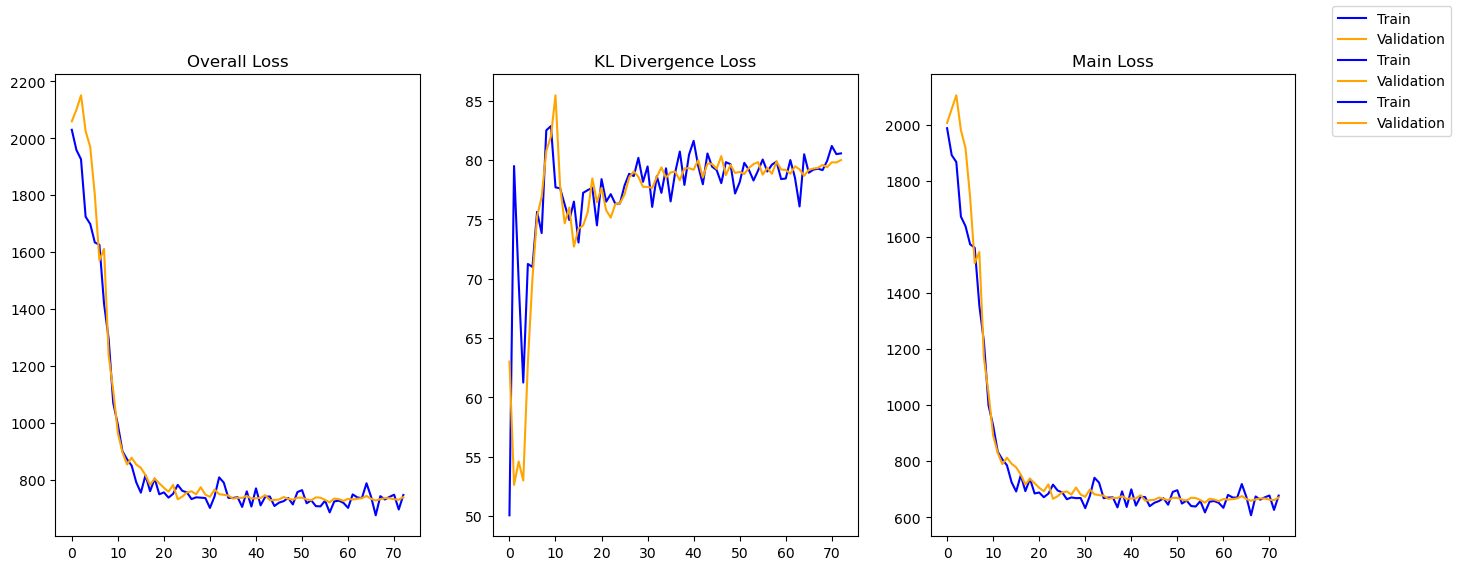

In [91]:
overall, kl_divergence, main = train(
    model=autoencoder,
    optimizer=optimizer,
    loss=loss,
    epochs=epochs,
    regularization_lambda=kl_divergence_lambda,
    dataloader=dataloader,
    val_dataset=alzheimer_dataset,
    scheduler=scheduler,
    plot=True,
    trial=None
)

overall_train_losses, val_overall_losses = overall
kl_divergence_train_losses, val_kl_divergence_train_losses = kl_divergence
main_train_losses, val_main_losses = main

In [92]:
image_to_generate = images[1]
# getting a generated image from the original
with torch.no_grad():
    # expanding the channel
    original_batched_image = np.expand_dims(image_to_generate, axis=0)
    # expanding batch
    original_batched_image = np.expand_dims(original_batched_image, axis=0)
    _, _, _, generated_image = autoencoder(torch.from_numpy(original_batched_image) \
                                  .to(device=device, dtype=torch.float32))
    
    generated_image = generated_image.flatten(start_dim=0, end_dim=2)
    print(generated_image.shape)

torch.Size([176, 144])


189.25422859191895

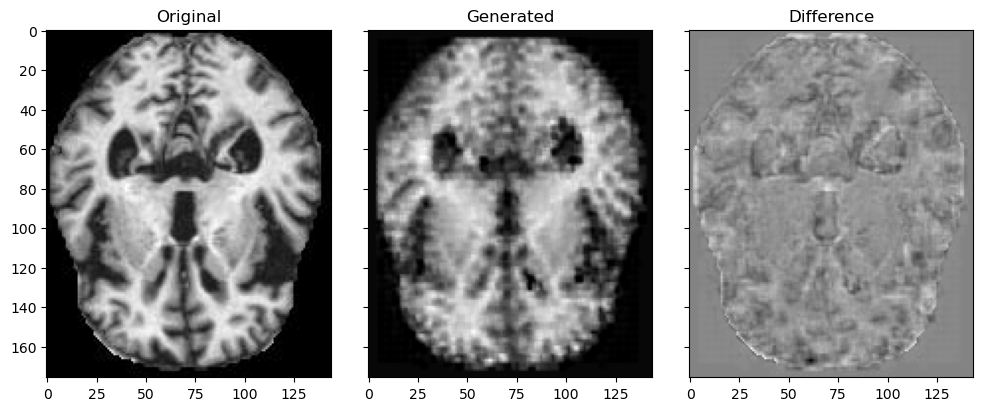

In [93]:
fig, axes = plt.subplots(1, 3, figsize=(10, 10), sharey=True, sharex=True)
fig.tight_layout()

axes[0].set_title('Original')
axes[0].imshow(image_to_generate, cmap='gray')
axes[1].set_title('Generated')
axes[1].imshow(generated_image.cpu(), cmap='gray')
axes[2].set_title('Difference')
axes[2].imshow(image_to_generate - generated_image.cpu().numpy(), cmap='gray')
(image_to_generate - generated_image.cpu().numpy()).max()

In [94]:
single_channel_images = np.expand_dims(images, axis=1)
# single_channels_images = dataset.X

with torch.no_grad():
    encoded_images, _, _, _ = encoder(torch.from_numpy(single_channel_images).to(device=device, dtype=torch.float32))
    encoded_images = encoded_images.cpu()

In [95]:
encoded_images.shape

torch.Size([10242, 2449])

In [96]:
with torch.no_grad():
    _, _, _, decoded_images = autoencoder(torch.from_numpy(single_channel_images).to(device=device, dtype=torch.float32))
    decoded_images = decoded_images.cpu()

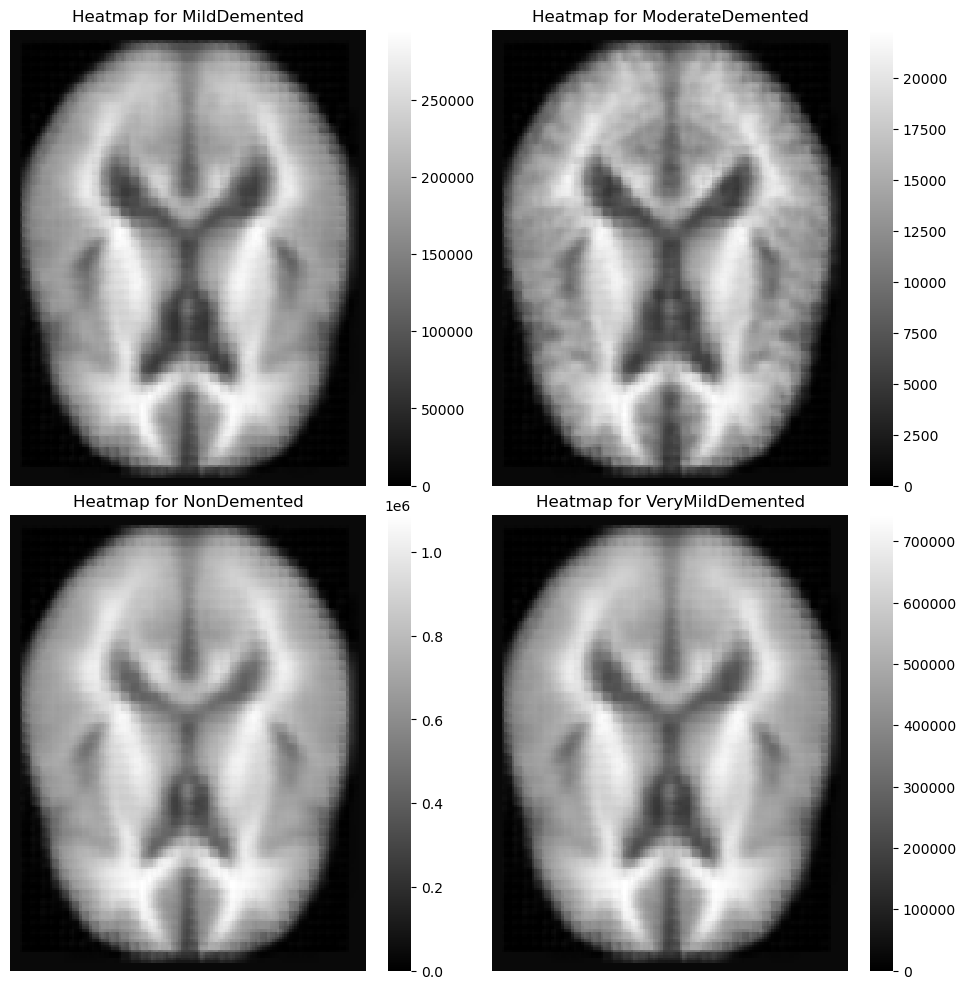

In [97]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True, sharex=True)
fig.tight_layout()

for i in range(len(classes)):
    ax = axes[i//2, i%2]
    class_images = decoded_images.squeeze().detach().numpy()[np.where(images_labels == i)]
    heatmap = np.sum(class_images, axis=0)
    sns.heatmap(heatmap, ax=ax, cmap='gray')
    ax.set_title(f'Heatmap for {classes[i]}')
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)

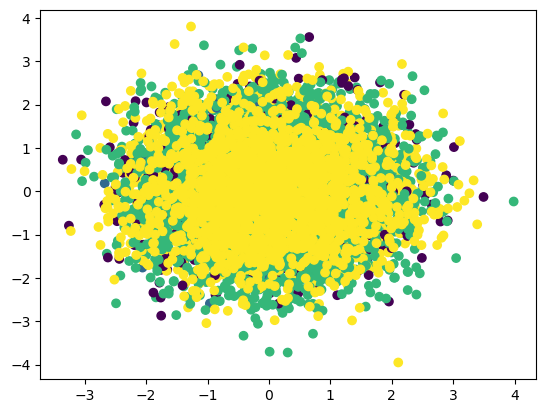

In [98]:
plt.scatter(encoded_images[:, 0], encoded_images[:, 1], c=images_labels)

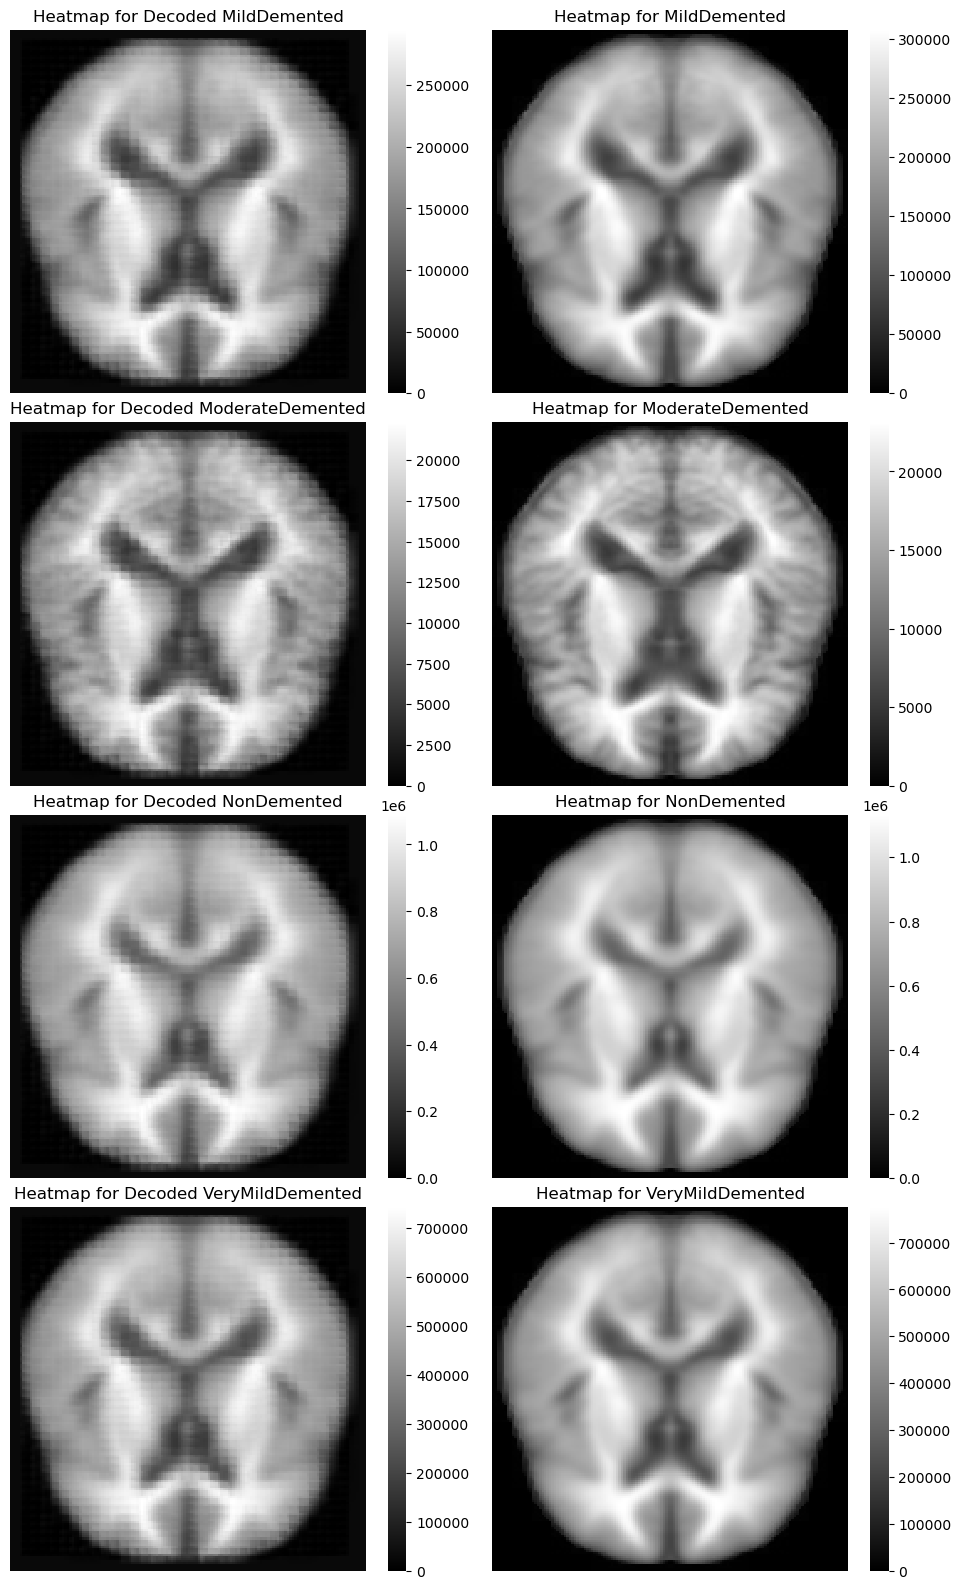

In [99]:
fig, axes = plt.subplots(4, 2, figsize=(10, 16), sharey=True, sharex=True)
fig.tight_layout()

for i in range(len(classes)):
    ax_generated = axes[i, 0]
    ax_original = axes[i, 1]
    generated_class_images = decoded_images.squeeze().detach().numpy()[np.where(images_labels == i)]
    original_class_images = images[np.where(images_labels == i)]
    original_heatmap = np.sum(original_class_images, axis=0)
    generated_heatmap = np.sum(generated_class_images, axis=0)
    sns.heatmap(generated_heatmap, ax=ax_generated, cmap='gray')
    sns.heatmap(original_heatmap, ax=ax_original, cmap='gray')
    
    ax_generated.set_title(f'Heatmap for Decoded {classes[i]}')
    ax_generated.get_yaxis().set_visible(False)
    ax_generated.get_xaxis().set_visible(False)
    
    ax_original.set_title(f'Heatmap for {classes[i]}')
    ax_original.get_yaxis().set_visible(False)
    ax_original.get_xaxis().set_visible(False)

In [100]:
def create_model_name(opt, params):
    final_name = f'{opt.__class__.__name__}-'
    for key, value in opt.state_dict()['param_groups'][0].items():
        if type(value) == type([]) or \
                key == 'differentiable' or \
                key == 'foreach' or \
                key == 'maximize' or \
                key == 'fused' or \
                key == 'nesterov':
            continue
        if key == 'lr':
            final_name += f'lr={params['lr']}-'
            continue
        final_name += f'{key}={value}-'
    final_name += f'kl_lambda={params['kl_divergence_lambda']}-'
    final_name += f'epochs={params['epochs']}-'
    final_name += f'encoded_dim={params['encoded_dim']}-'
    final_name += f'channels={params['initial_out_channels']}-'
    final_name += f'bs={params['batch_size']}'
    return final_name

In [101]:
def save_model(model, opt, params):
    file_name_prefix = f'./saved_models/{create_model_name(opt, params)}'
    file_name = f'{file_name_prefix}.pt'
    if os.path.exists(file_name):
        counter = 0
        file_name = f'{file_name_prefix}-{counter}.pt'
        while os.path.exists(file_name):
            print(f'file {file_name} already exists, creating a new file...')
            counter += 1
            file_name = f'{file_name_prefix}-{counter}.pt'
    print(f'length: {len(file_name)}')
    torch.save(model.state_dict(), file_name)
    print(f'file {file_name} created.')

In [102]:
save_model(autoencoder, optimizer, best_params)

length: 242
file ./saved_models/SGD-lr=0.007549266317526356-momentum=0.47051274012690153-dampening=0.03621857940939195-weight_decay=0.10448724804178021-initial_lr=0.007549266317526356-kl_lambda=0.8511764796628465-epochs=73-encoded_dim=2449-channels=8-bs=56.pt created.


#### Adding noise to the encoded images and decoding the result to create new images

In [103]:
final_images = np.concatenate((np.expand_dims(images, axis=1), decoded_images), axis=0)
final_labels = np.concatenate((images_labels, images_labels), axis=0)

In [104]:
desired_min_images = 50000
# number of times we'll add noise and decode the result
num_iterations = desired_min_images // encoded_images.shape[0]

for i in tqdm(range(num_iterations)):
    encoded_noise = np.random.randn(*encoded_images.cpu().numpy().shape)
    noisy_images = encoded_images.cpu().numpy() + encoded_noise
    
    with torch.no_grad():
        noisy_decoded_images = decoder(torch.from_numpy(noisy_images).to(device=device, dtype=torch.float32)).cpu()
    
    final_images = np.concatenate((final_images, noisy_decoded_images), axis=0)
    final_labels = np.concatenate((final_labels, images_labels), axis=0)

100%|██████████| 4/4 [00:30<00:00,  7.63s/it]


In [105]:
final_images.shape, final_labels.shape

((61452, 1, 176, 144), (61452,))

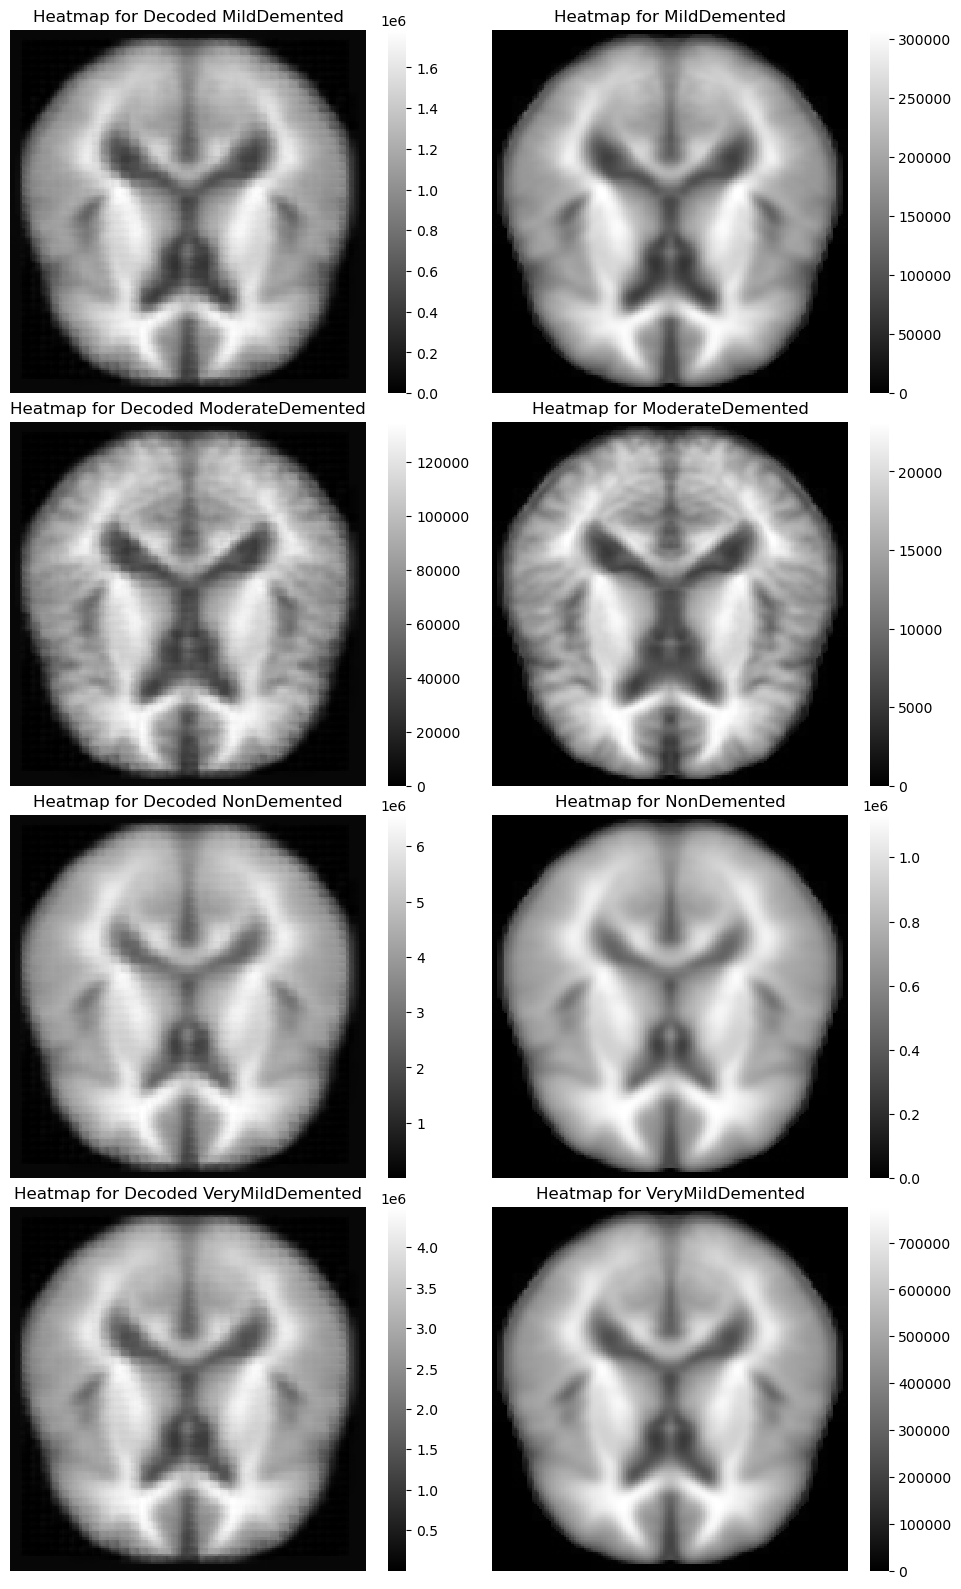

In [106]:
fig, axes = plt.subplots(4, 2, figsize=(10, 16), sharey=True, sharex=True)
fig.tight_layout()

for i in range(len(classes)):
    ax_generated = axes[i, 0]
    ax_original = axes[i, 1]
    generated_class_images = final_images.squeeze()[np.where(final_labels == i)]
    original_class_images = images[np.where(images_labels == i)]
    original_heatmap = np.sum(original_class_images, axis=0)
    generated_heatmap = np.sum(generated_class_images, axis=0)
    sns.heatmap(generated_heatmap, ax=ax_generated, cmap='gray')
    sns.heatmap(original_heatmap, ax=ax_original, cmap='gray')

    ax_generated.set_title(f'Heatmap for Decoded {classes[i]}')
    ax_generated.get_yaxis().set_visible(False)
    ax_generated.get_xaxis().set_visible(False)

    ax_original.set_title(f'Heatmap for {classes[i]}')
    ax_original.get_yaxis().set_visible(False)
    ax_original.get_xaxis().set_visible(False)

#### Saving the decoded and generated images to disk for later use

In [107]:
from PIL import Image

In [108]:
directory_name = './data/decoded_data_2'
if not os.path.exists(directory_name):
    os.mkdir(directory_name)
    for i in range(len(classes)):
        os.mkdir(f'{directory_name}/{classes[i]}')

    for image_idx in tqdm(range(final_images.shape[0])):
        # setting image to be of shape (H x W x C)
        image = final_images[image_idx].squeeze().astype(np.uint8)
        image = Image.fromarray(image)
        image_directory = f'{directory_name}/{classes[int(final_labels[image_idx])]}'
        image.save(f'{image_directory}/{image_idx}.jpg')

100%|██████████| 61452/61452 [00:45<00:00, 1363.10it/s]


In [109]:
del final_images
del final_labels